In [1]:
import torch

from transformers import PreTrainedModel
from trader_models import SGConvConfig, SGConvTrader
import datasets
from datasets import load_dataset, Dataset, DatasetDict

from torch.utils.data import DataLoader
from transformers import Trainer, TrainingArguments

import numpy as np

import logging
logging.disable(logging.INFO)

In [2]:
from robust_loss import NCEandRCE
import torch

# Example of target with class indices
loss = NCEandRCE(alpha = 1, beta = 1, num_classes = 5)
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
loss(input, target)

tensor(7.2997, grad_fn=<AddBackward0>)

In [3]:
def compute_metrics(preds):
    class_loss, trade_loss, soft_profit, soft_trade = preds.predictions
    abs_trade = np.abs(soft_trade)
    abs_trade = abs_trade.astype('float64') # half precision will cause the sum to overflow on next line
    trades = abs_trade.sum()
    
    day_profits = soft_profit.sum(axis = (1, 2))
    
    metrics = {
        'classification loss': np.mean(class_loss),
        'trade loss * 100': np.mean(trade_loss) * 100, # easier to see decimals
        'day profit': day_profits.mean(),
        'day sharpe': day_profits.mean() / day_profits.std(),
        'trade %': trades * 100 / soft_profit.size,

        'full trade %': (abs_trade >= .75).mean() * 100,
        'full trade accuracy': (soft_profit[abs_trade >= .75] > 0).mean() * 100,
        'full trade g/l': soft_profit[(abs_trade >= .75) & (soft_profit > 0)].mean()
                          / -soft_profit[(abs_trade >= .75) & (soft_profit < 0)].mean(),

        'medium trade %': ((abs_trade < .75) & (abs_trade >= .45)).mean() * 100,
        'medium trade accuracy': (soft_profit[(abs_trade < .75) & (abs_trade >= .45)] > 0).mean() * 100,
        'medium trade g/l': soft_profit[(abs_trade < .75) & (abs_trade >= .45) & (soft_profit > 0)].mean()
                            / -soft_profit[(abs_trade < .75) & (abs_trade >= .45) & (soft_profit < 0)].mean(),       

        'small trade %': ((abs_trade < .45) & (abs_trade >= .25)).mean() * 100,
        'small trade accuracy': (soft_profit[(abs_trade < .45) & (abs_trade >= .25)] > 0).mean() * 100,
        'small trade g/l': soft_profit[(abs_trade < .45) & (abs_trade >= .25) & (soft_profit > 0)].mean()
                            / -soft_profit[(abs_trade < .45) & (abs_trade >= .25) & (soft_profit < 0)].mean(),        
    }
    
    # round the metrics
    metrics = {k: np.format_float_positional(v, precision = 4) for k, v in metrics.items()}
    
    return metrics

In [4]:
# fx = Dataset.load_from_disk('Currency_Data/fx_days')

# only majors (works better currently)
fx = Dataset.load_from_disk('Currency_Data/major_days')

# random data for testing of pipeline
# fx = Dataset.load_from_disk('Currency_Data/random_days')

In [5]:
# make splits
split = fx.train_test_split(120/len(fx), shuffle = False)
valid_test = split['test'].train_test_split(.3, shuffle = False)
fx = DatasetDict({
    'train': split['train'],
    'validation': valid_test['train'],
    'test': valid_test['test']
})

In [6]:
fx

DatasetDict({
    train: Dataset({
        features: ['ohlcv', 'overnight_masks', 'labels', 'classes'],
        num_rows: 46311
    })
    validation: Dataset({
        features: ['ohlcv', 'overnight_masks', 'labels', 'classes'],
        num_rows: 84
    })
    test: Dataset({
        features: ['ohlcv', 'overnight_masks', 'labels', 'classes'],
        num_rows: 37
    })
})

In [7]:
batch_size = 8

training_args = TrainingArguments(
    output_dir = "./results",
    logging_strategy = "steps",
    evaluation_strategy = "steps",
    logging_steps = np.round(len(fx['train']) / batch_size / 35, -2), # about 35 updates
    eval_steps = np.round(len(fx['train']) / batch_size / 35, -2),
    save_steps = len(fx['train']), # don't save
    report_to = "none",
    learning_rate = 1e-3,
    adam_beta2 = .98,
    # weight_decay = 0.1,
    lr_scheduler_type = "cosine",
    warmup_ratio = .05,
    num_train_epochs = 1,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    max_grad_norm = 1,
    fp16 = True
)

In [8]:
hidden_size = 320

config = SGConvConfig(
    n_embd = hidden_size, n_head = hidden_size // 64, kernel_size = 10,
    hidden_dropout_prob = 0, num_levels = 21,
    max_loss = .9, use_swiglu = False, commission = 0.01
)

model = SGConvTrader(config)
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = fx['train'],
    eval_dataset = fx['validation'],
    compute_metrics = compute_metrics
)

# get parameter information
total_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'PARAMETER COUNT: {total_parameters}, with commas {total_parameters:,}')

Using 13 layers
PARAMETER COUNT: 11051325, with commas 11,051,325


In [9]:
# majors only
# tanh based embeddings, no embedding norm or final norm, USE output biases, *kernel size = 10*
# log returns/growth maximization!! max loss set at .5 (1% = .5 point commission)
# hidden size 320 (SMALL RUN) 10M, ff size 2x, trade log loss & classification loss
# rotary, rmsnorm, normal gelu activation *(no biases)*

# (DIVERGED)

# lr of 1e-3, batch size 8, adam beta .98s, no dropout or weight decay
# stds fixed, fp16
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Classification loss,Trade loss * 100,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,3.575300,3.370375,3.3737,0.0015,-0.0379,-0.1325,0.1163,0.,nan,nan,0.,nan,nan,0.,nan,nan
400,3.409400,3.375420,3.3786,0.0012,-0.0337,-0.1027,0.0879,0.,nan,nan,0.,nan,nan,0.,nan,nan
600,3.395300,3.367217,3.3702,0.0028,-0.1975,-0.1452,0.1292,0.,nan,nan,0.,nan,nan,0.,nan,nan
800,3.395300,3.355019,3.358,0.0019,-0.1031,-0.136,0.1104,0.,nan,nan,0.,nan,nan,0.,nan,nan
1000,3.391000,3.354007,3.3568,0.002,-0.0889,-0.1647,0.121,0.,nan,nan,0.,nan,nan,0.,nan,nan
1200,3.379800,3.349693,3.3528,0.0008,-0.0501,-0.1911,0.0416,0.,nan,nan,0.,nan,nan,0.,nan,nan
1400,3.442800,3.483424,3.4863,0.0013,0.0492,0.0528,0.0255,0.,nan,nan,0.,nan,nan,0.0614,54.1916,0.8694
1600,32.854700,36.869618,36.8935,-0.0000,0.0000,0.0434,0.0000,0.,nan,nan,0.,nan,nan,0.,nan,nan


<ipython-input-3-6453d0485cd6>:17: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .75] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-6453d0485cd6>:18: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .75) & (soft_profit > 0)].mean()
<ipython-input-3-6453d0485cd6>:19: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .75) & (soft_profit < 0)].mean(),
<ipython-input-3-6453d0485cd6>:22: RuntimeWarning: Mean of empty slice.
  'medium trade accuracy': (soft_profit[(abs_trade < .75) & (abs_trade >= .45)] > 0).mean() * 100,
<ipython-input-3-6453d0485cd6>:23: RuntimeWarning: Mean of empty slice.
  'medium trade g/l': soft_profit[(abs_trade < .75) & (abs_trade >= .45) & (soft_profit > 0)].mean()
<ipython-input-3-6453d0485cd6>:24: RuntimeWarning: Me

KeyboardInterrupt: 

In [9]:
# majors only
# tanh based embeddings, no embedding norm or final norm, USE output biases, *kernel size = 10*
# log returns/growth maximization!! max loss set at .5 (1% = .5 point commission)
# hidden size 320 (SMALL RUN) 10M, ff size 2x, trade log loss & classification loss
# rotary, rmsnorm, normal gelu activation

# lr of 1e-3, batch size 8, adam beta .98s, no dropout or weight decay
# stds fixed, fp16
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Classification loss,Trade loss * 100,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,3.575500,3.369781,3.3727,0.0009,0.0324,0.0812,0.1128,0.,nan,nan,0.,nan,nan,0.,nan,nan
400,3.409300,3.375479,3.3786,0.0017,-0.0796,-0.0804,0.1082,0.,nan,nan,0.,nan,nan,0.,nan,nan
600,3.395300,3.368111,3.3711,0.0011,-0.0628,-0.1166,0.0627,0.,nan,nan,0.,nan,nan,0.,nan,nan
800,3.395100,3.355758,3.3586,0.0015,-0.0285,-0.0543,0.1172,0.,nan,nan,0.,nan,nan,0.,nan,nan
1000,3.390700,3.352733,3.3558,0.0007,0.0287,0.0501,0.0823,0.,nan,nan,0.,nan,nan,0.,nan,nan
1200,3.379900,3.349955,3.353,0.0017,-0.1054,-0.1369,0.0861,0.,nan,nan,0.,nan,nan,0.,nan,nan
1400,3.382900,3.360252,3.363,0.0005,0.0157,0.0673,0.0607,0.,nan,nan,0.,nan,nan,0.,nan,nan
1600,3.386300,3.355770,3.3584,-0.0006,0.2747,0.2028,0.1400,0.,nan,nan,0.,nan,nan,0.,nan,nan
1800,3.391200,3.366077,3.3688,0.0003,0.0233,0.1247,0.0437,0.,nan,nan,0.,nan,nan,0.,nan,nan
2000,3.415800,3.404248,3.4055,0.0581,1.4359,0.044,3.1411,0.,nan,nan,0.0007,100.,nan,1.423,48.88,1.0837


<ipython-input-3-6453d0485cd6>:17: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .75] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-6453d0485cd6>:18: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .75) & (soft_profit > 0)].mean()
<ipython-input-3-6453d0485cd6>:19: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .75) & (soft_profit < 0)].mean(),
<ipython-input-3-6453d0485cd6>:22: RuntimeWarning: Mean of empty slice.
  'medium trade accuracy': (soft_profit[(abs_trade < .75) & (abs_trade >= .45)] > 0).mean() * 100,
<ipython-input-3-6453d0485cd6>:23: RuntimeWarning: Mean of empty slice.
  'medium trade g/l': soft_profit[(abs_trade < .75) & (abs_trade >= .45) & (soft_profit > 0)].mean()
<ipython-input-3-6453d0485cd6>:24: RuntimeWarning: Me

KeyboardInterrupt: 

In [9]:
# majors only
# tanh based embeddings, no embedding norm, *use final norm*, USE output biases, *kernel size = 10*
# log returns/growth maximization!! max loss set at .5 (1% = .5 point commission)
# hidden size 320 (SMALL RUN) 10M, ff size 2x, trade log loss & classification loss
# rotary, rmsnorm, normal gelu activation

# (DIVERGED)

# lr of 1e-3, batch size 8, adam beta .98s, no dropout or weight decay
# stds fixed, fp16
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Classification loss,Trade loss * 100,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,3.580600,3.366099,3.3692,-0.0006,0.3815,0.1261,0.2006,0.,nan,nan,0.,nan,nan,0.,nan,nan
400,3.403900,3.364975,3.3680,0.0003,0.0046,0.0647,0.0332,0.,nan,nan,0.,nan,nan,0.,nan,nan
600,3.392100,3.361789,3.3647,0.0028,-0.1651,-0.1475,0.1611,0.,nan,nan,0.,nan,nan,0.,nan,nan
800,3.395800,3.361318,3.3639,0.0003,0.0134,0.1078,0.0432,0.,nan,nan,0.,nan,nan,0.,nan,nan
1000,3.394800,3.354392,3.3572,0.0002,0.0128,0.1822,0.0329,0.,nan,nan,0.,nan,nan,0.,nan,nan
1200,3.436600,3.556093,3.5555,0.0029,-0.1195,-0.1255,0.1953,0.,nan,nan,0.,nan,nan,0.,nan,nan
1400,3.621500,3.770864,3.7618,0.0000,0.0001,0.086,0.0013,0.,nan,nan,0.,nan,nan,0.,nan,nan
1600,4.099600,4.915844,4.8927,0.0000,0.0000,0.0379,0.0003,0.,nan,nan,0.,nan,nan,0.,nan,nan


<ipython-input-3-6453d0485cd6>:17: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .75] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-6453d0485cd6>:18: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .75) & (soft_profit > 0)].mean()
<ipython-input-3-6453d0485cd6>:19: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .75) & (soft_profit < 0)].mean(),
<ipython-input-3-6453d0485cd6>:22: RuntimeWarning: Mean of empty slice.
  'medium trade accuracy': (soft_profit[(abs_trade < .75) & (abs_trade >= .45)] > 0).mean() * 100,
<ipython-input-3-6453d0485cd6>:23: RuntimeWarning: Mean of empty slice.
  'medium trade g/l': soft_profit[(abs_trade < .75) & (abs_trade >= .45) & (soft_profit > 0)].mean()
<ipython-input-3-6453d0485cd6>:24: RuntimeWarning: Me

KeyboardInterrupt: 

In [9]:
# all data
# tanh based embeddings, no embedding norm or final norm, *USE output biases*, kernel size = 1
# log returns/growth maximization!! max loss set at .5 (1% = .5 point commission)
# hidden size *512 (MED RUN) 41M*, ff size 1x, *trade log loss* & classification loss

# *lr of 1e-3*, batch size 8, adam beta .98s, no dropout or weight decay
# stds fixed, fp16
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Classification loss,Trade loss * 100,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
1300,3.375200,3.413283,3.4151,0.0227,-1.6159,-0.1050,0.8849,0.,nan,nan,0.,nan,nan,0.0006,50.,0.2946
2600,3.322300,3.396044,3.3975,0.0048,-0.2373,-0.0948,0.2773,0.,nan,nan,0.0015,93.75,12.8566,0.0010,54.5455,0.4986
3900,3.315200,3.391400,3.3933,0.0005,-0.0431,-0.1218,0.0186,0.,nan,nan,0.0004,50.,2.5175,0.0012,76.9231,0.9945
5200,3.311900,3.386891,3.3886,0.0016,-0.1132,-0.1867,0.0715,0.0004,75.,0.0786,0.0010,54.5455,1.731,0.0025,77.7778,1.0006
6500,3.308700,3.394267,3.3961,0.0007,-0.0088,-0.0098,0.0643,0.0006,71.4286,0.1650,0.0058,57.1429,0.8761,0.0417,42.7313,0.9098
7800,3.308000,3.388978,3.3908,0.0029,-0.0413,-0.0237,0.2347,0.0022,75.,0.4105,0.0071,71.4286,1.194,0.1010,47.7273,0.9448
9100,3.309200,3.386981,3.3889,-0.0067,1.628,0.2160,0.4183,0.0533,68.9655,1.2126,0.2063,70.2137,1.6414,0.2299,63.2441,1.2858
10400,3.303000,3.392463,3.3946,-0.0030,0.8129,0.2672,0.2699,0.0096,75.9615,1.2907,0.052,74.2049,1.7298,0.166,58.5501,0.9418
11700,3.307700,3.381668,3.3839,-0.0168,3.1441,0.3659,0.5156,0.0455,79.1919,1.3232,0.2975,74.1278,1.5469,0.3865,64.2110,1.1598
13000,3.300800,3.374525,3.3768,-0.0081,1.7073,0.2906,0.3924,0.0322,78.6325,1.2395,0.1557,71.3864,1.3772,0.2664,61.2759,1.2024


<ipython-input-3-6453d0485cd6>:17: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .75] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-6453d0485cd6>:18: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .75) & (soft_profit > 0)].mean()
<ipython-input-3-6453d0485cd6>:19: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .75) & (soft_profit < 0)].mean(),
<ipython-input-3-6453d0485cd6>:22: RuntimeWarning: Mean of empty slice.
  'medium trade accuracy': (soft_profit[(abs_trade < .75) & (abs_trade >= .45)] > 0).mean() * 100,
<ipython-input-3-6453d0485cd6>:23: RuntimeWarning: Mean of empty slice.
  'medium trade g/l': soft_profit[(abs_trade < .75) & (abs_trade >= .45) & (soft_profit > 0)].mean()
<ipython-input-3-6453d0485cd6>:24: RuntimeWarning: Me

TrainOutput(global_step=45227, training_loss=3.2953933357182934, metrics={'train_runtime': 23768.047, 'train_samples_per_second': 15.223, 'train_steps_per_second': 1.903, 'total_flos': 0.0, 'train_loss': 3.2953933357182934, 'epoch': 1.0})

In [ ]:
# all data
# tanh based embeddings, no embedding norm or final norm, *USE output biases*, kernel size = 1
# log returns/growth maximization!! max loss set at .5 (1% = .5 point commission)
# hidden size *320 (MED RUN) 9M*, ff size 1x, *trade log loss* & classification loss

# *lr of 1e-3*, batch size 8, adam beta .98s, no dropout or weight decay
# stds fixed, fp16
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Classification loss,Trade loss * 100,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
1300,3.387600,3.399452,3.4013,0.0109,-0.7398,-0.1,0.5012,0.,nan,nan,0.,nan,nan,0.,nan,nan
2600,3.317900,3.391761,3.3934,0.0025,0.4695,0.1326,0.5736,0.,nan,nan,0.0005,100.,nan,0.0031,79.4118,0.5108
3900,3.311500,3.389088,3.3909,-0.0005,0.1534,0.1714,0.0863,0.0001,0.,nan,0.0006,14.2857,1.0251,0.0008,33.3333,1.0436
5200,3.309900,3.382307,3.3841,-0.0001,0.2975,0.2180,0.1973,0.0055,61.6667,0.9834,0.0126,74.4526,1.2424,0.0139,74.1722,1.5112
6500,3.306500,3.398490,3.4005,0.0009,0.1748,0.1456,0.1956,0.0262,74.386,0.9053,0.0217,77.1186,1.0568,0.0186,84.6535,0.9244
7800,3.306800,3.385888,3.3878,0.0011,0.2001,0.1142,0.2205,0.0265,77.0833,0.8629,0.0289,73.9683,1.1589,0.0422,62.963,1.0765
9100,3.307400,3.383660,3.3855,0.0005,0.4256,0.1431,0.3105,0.0512,80.6104,0.9171,0.0479,76.8199,1.4657,0.1131,63.2819,1.1404
10400,3.301100,3.387933,3.3898,0.0055,-0.0973,-0.0441,0.3657,0.0085,67.3913,0.5669,0.0382,63.9423,0.8123,0.1179,54.6376,0.898
11700,3.306000,3.378030,3.3803,-0.0039,1.4070,0.2659,0.5928,0.0280,80.3279,1.0578,0.1270,68.6913,1.2827,0.3497,59.7583,1.0307
13000,3.299300,3.372818,3.3749,-0.0033,0.9991,0.2893,0.3696,0.0615,79.8507,0.9598,0.094,77.6149,1.0420,0.1848,60.2883,1.0878


<ipython-input-3-6453d0485cd6>:17: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .75] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-6453d0485cd6>:18: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .75) & (soft_profit > 0)].mean()
<ipython-input-3-6453d0485cd6>:19: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .75) & (soft_profit < 0)].mean(),
<ipython-input-3-6453d0485cd6>:22: RuntimeWarning: Mean of empty slice.
  'medium trade accuracy': (soft_profit[(abs_trade < .75) & (abs_trade >= .45)] > 0).mean() * 100,
<ipython-input-3-6453d0485cd6>:23: RuntimeWarning: Mean of empty slice.
  'medium trade g/l': soft_profit[(abs_trade < .75) & (abs_trade >= .45) & (soft_profit > 0)].mean()
<ipython-input-3-6453d0485cd6>:24: RuntimeWarning: Me

In [9]:
# all data
# tanh based embeddings, no embedding norm or final norm, *USE output biases*
# log returns/growth maximization!! max loss set at .5 (1% = .5 point commission)
# hidden size *320 (MED RUN) 9M*, ff size 1x, *trade log loss* & classification loss

# *lr of 1e-3*, batch size 8, adam beta .98s, no dropout or weight decay
# stds fixed, fp16
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Classification loss,Trade loss * 100,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
1300,3.373400,3.379079,3.3811,0.0145,-0.7015,-0.0701,0.8327,0.,nan,nan,0.,nan,nan,0.,nan,nan
2600,3.296900,3.368452,3.3707,0.0060,0.8456,0.1018,1.1940,0.0082,58.427,1.2974,0.0734,71.7146,1.2045,0.1036,73.8475,0.9309
3900,3.291200,3.361256,3.3635,-0.0017,1.6948,0.4227,1.0997,0.0474,85.0775,1.502,0.1160,76.4846,1.2938,0.1585,68.54,1.1764
5200,3.289300,3.368982,3.3713,0.0018,1.2062,0.2593,0.9897,0.1014,81.3406,1.6135,0.1498,71.3059,1.1993,0.166,65.3569,0.9604
6500,3.286600,3.368344,3.3703,-0.0036,1.8148,0.3723,0.8675,0.1662,79.3256,1.13,0.1856,69.6685,0.959,0.1777,67.5452,1.0347
7800,3.287200,3.359242,3.3614,0.0114,1.2034,0.0811,1.6314,0.2014,79.6533,1.0580,0.1903,72.3938,1.0420,0.3233,60.2557,1.1244
9100,3.289100,3.362753,3.3649,-0.0128,3.3666,0.5854,1.0957,0.2758,79.8535,1.2123,0.2618,70.4912,1.1331,0.3079,62.1420,1.1485
10400,3.282400,3.361081,3.3634,0.0012,1.4709,0.3116,0.9758,0.1647,78.7507,1.1648,0.2285,61.2384,0.7974,0.3470,57.3584,1.0631
11700,3.288000,3.354743,3.3571,-0.0146,5.4798,0.4478,2.164,0.6273,71.4014,1.0686,0.878,61.2367,1.0665,0.9088,58.9751,1.3060
13000,3.281600,3.353959,3.3561,-0.0087,2.6326,0.3762,0.9192,0.3568,73.1977,0.9262,0.2752,69.5594,1.1477,0.2528,63.0451,1.3008


<ipython-input-3-6453d0485cd6>:17: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .75] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-6453d0485cd6>:18: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .75) & (soft_profit > 0)].mean()
<ipython-input-3-6453d0485cd6>:19: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .75) & (soft_profit < 0)].mean(),
<ipython-input-3-6453d0485cd6>:22: RuntimeWarning: Mean of empty slice.
  'medium trade accuracy': (soft_profit[(abs_trade < .75) & (abs_trade >= .45)] > 0).mean() * 100,
<ipython-input-3-6453d0485cd6>:23: RuntimeWarning: Mean of empty slice.
  'medium trade g/l': soft_profit[(abs_trade < .75) & (abs_trade >= .45) & (soft_profit > 0)].mean()
<ipython-input-3-6453d0485cd6>:24: RuntimeWarning: Me

TrainOutput(global_step=45227, training_loss=3.277078675478351, metrics={'train_runtime': 19305.2791, 'train_samples_per_second': 18.742, 'train_steps_per_second': 2.343, 'total_flos': 0.0, 'train_loss': 3.277078675478351, 'epoch': 1.0})

In [9]:
# *only majors* -- Trying to see if improvements hold on small data
# tanh based embeddings, no embedding norm or final norm, *USE output biases*
# log returns/growth maximization!! max loss set at .5 (1% = .5 point commission)
# hidden size *320 (MED RUN) 9M*, ff size 1x, *2x trade log loss* & classification loss

# *lr of 1e-3*, batch size 8, adam beta .98s, no dropout or weight decay
# stds fixed, fp16
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Classification loss,Trade loss * 100,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,3.552600,3.369748,3.3726,0.0003,0.0178,0.0927,0.0425,0.,nan,nan,0.,nan,nan,0.,nan,nan
400,3.390800,3.372407,3.3754,0.0001,0.468,0.0943,0.2932,0.,nan,nan,0.,nan,nan,0.,nan,nan
600,3.379100,3.363311,3.3661,0.0005,0.0314,0.0846,0.0705,0.,nan,nan,0.,nan,nan,0.,nan,nan
800,3.381800,3.356802,3.3596,0.0008,0.7814,0.0940,0.515,0.,nan,nan,0.,nan,nan,0.,nan,nan
1000,3.375700,3.360932,3.3639,0.0005,0.0788,0.1035,0.099,0.,nan,nan,0.0037,62.5,0.4027,0.0128,60.4317,0.6713
1200,3.364700,3.355043,3.3579,-0.0006,0.3405,0.2135,0.1764,0.0015,50.,0.6363,0.049,68.4803,0.7018,0.0498,75.8303,0.877
1400,3.366800,3.356669,3.3594,-0.0012,0.344,0.2324,0.1468,0.0014,80.,0.9161,0.0247,75.4647,1.4189,0.0396,78.8863,1.1482
1600,3.371800,3.356201,3.3589,-0.0009,1.2633,0.1373,0.6763,0.1630,76.5070,0.9459,0.1733,74.0329,0.9501,0.0721,74.1401,1.2291
1800,3.371100,3.378299,3.3815,-0.0051,1.0974,0.4653,0.2731,0.1121,80.4098,1.243,0.1185,75.5814,1.0617,0.0675,71.1565,1.0783
2000,3.374200,3.353774,3.3568,-0.0039,1.1522,0.3013,0.4185,0.0909,83.5354,1.1555,0.1136,76.8795,0.9406,0.0905,72.6904,1.0259


<ipython-input-3-6453d0485cd6>:17: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .75] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-6453d0485cd6>:18: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .75) & (soft_profit > 0)].mean()
<ipython-input-3-6453d0485cd6>:19: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .75) & (soft_profit < 0)].mean(),
<ipython-input-3-6453d0485cd6>:22: RuntimeWarning: Mean of empty slice.
  'medium trade accuracy': (soft_profit[(abs_trade < .75) & (abs_trade >= .45)] > 0).mean() * 100,
<ipython-input-3-6453d0485cd6>:23: RuntimeWarning: Mean of empty slice.
  'medium trade g/l': soft_profit[(abs_trade < .75) & (abs_trade >= .45) & (soft_profit > 0)].mean()
<ipython-input-3-6453d0485cd6>:24: RuntimeWarning: Me

TrainOutput(global_step=5789, training_loss=3.365049835642625, metrics={'train_runtime': 2455.4003, 'train_samples_per_second': 18.861, 'train_steps_per_second': 2.358, 'total_flos': 0.0, 'train_loss': 3.365049835642625, 'epoch': 1.0})

In [9]:
# *only majors* -- Trying to see if improvements hold on small data
# tanh based embeddings, no embedding norm, *use final norm*, no output biases
# log returns/growth maximization!! max loss set at .5 (1% = .5 point commission)
# hidden size *320 (MED RUN) 9M*, ff size 1x, *2x trade log loss* & classification loss

# *lr of 1e-3*, batch size 8, adam beta .98s, no dropout or weight decay
# stds fixed, fp16
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Classification loss,Trade loss * 100,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,3.564200,3.373078,3.3761,-0.0002,0.0595,0.1816,0.0287,0.,nan,nan,0.,nan,nan,0.,nan,nan
400,3.391000,3.377092,3.3801,-0.0001,0.0271,0.0872,0.0108,0.,nan,nan,0.,nan,nan,0.,nan,nan
600,3.381700,3.369403,3.3725,0.0000,-0.0031,-0.1228,0.0013,0.,nan,nan,0.,nan,nan,0.,nan,nan
800,3.383500,3.359871,3.3629,0.0000,-0.0000,-0.0061,0.0003,0.,nan,nan,0.,nan,nan,0.,nan,nan
1000,3.378200,3.362953,3.3661,-0.0000,0.001,0.1235,0.0004,0.,nan,nan,0.,nan,nan,0.,nan,nan
1200,3.365900,3.356625,3.3596,-0.0000,0.0005,0.1771,0.0001,0.,nan,nan,0.,nan,nan,0.,nan,nan
1400,3.368300,3.357275,3.3601,0.0000,-0.0001,-0.0628,0.0002,0.,nan,nan,0.,nan,nan,0.,nan,nan
1600,3.373300,3.355515,3.3584,0.0000,-0.0011,-0.0860,0.0006,0.,nan,nan,0.,nan,nan,0.,nan,nan
1800,3.372400,3.363095,3.3661,0.0000,-0.0001,-0.0885,0.0001,0.,nan,nan,0.,nan,nan,0.,nan,nan
2000,3.374700,3.352862,3.3557,0.0000,-0.0009,-0.1015,0.0005,0.,nan,nan,0.,nan,nan,0.,nan,nan


<ipython-input-3-6453d0485cd6>:17: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .75] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-6453d0485cd6>:18: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .75) & (soft_profit > 0)].mean()
<ipython-input-3-6453d0485cd6>:19: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .75) & (soft_profit < 0)].mean(),
<ipython-input-3-6453d0485cd6>:22: RuntimeWarning: Mean of empty slice.
  'medium trade accuracy': (soft_profit[(abs_trade < .75) & (abs_trade >= .45)] > 0).mean() * 100,
<ipython-input-3-6453d0485cd6>:23: RuntimeWarning: Mean of empty slice.
  'medium trade g/l': soft_profit[(abs_trade < .75) & (abs_trade >= .45) & (soft_profit > 0)].mean()
<ipython-input-3-6453d0485cd6>:24: RuntimeWarning: Me

TrainOutput(global_step=5789, training_loss=3.3661123365704353, metrics={'train_runtime': 2415.9569, 'train_samples_per_second': 19.169, 'train_steps_per_second': 2.396, 'total_flos': 0.0, 'train_loss': 3.3661123365704353, 'epoch': 1.0})

In [9]:
# *only majors* -- Trying to see if improvements hold on small data
# tanh based embeddings, no embedding norm or final norm, no output biases
# log returns/growth maximization!! max loss set at .5 (1% = .5 point commission)
# hidden size *320 (MED RUN) 9M*, ff size 1x, *2x trade log loss* & classification loss

# *lr of 1e-3*, batch size 8, adam beta .98s, no dropout or weight decay
# stds fixed, fp16
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Classification loss,Trade loss * 100,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,3.556700,3.372697,3.3756,0.0004,0.0967,0.0936,0.1001,0.,nan,nan,0.,nan,nan,0.,nan,nan
400,3.392000,3.376548,3.3795,0.0011,0.9990,0.0869,0.6175,0.,nan,nan,0.,nan,nan,0.,nan,nan
600,3.379600,3.363066,3.3658,0.001,-0.0514,-0.0676,0.0589,0.,nan,nan,0.,nan,nan,0.,nan,nan
800,3.381800,3.361265,3.3642,0.0016,0.1228,0.0453,0.2176,0.,nan,nan,0.,nan,nan,0.,nan,nan
1000,3.376200,3.361971,3.3650,0.0001,0.1419,0.101,0.0961,0.,nan,nan,0.,nan,nan,0.0002,50.,1.2365
1200,3.365000,3.354095,3.3571,-0.0024,0.6854,0.1450,0.2312,0.,nan,nan,0.0017,52.6316,1.1191,0.0051,71.4286,0.9951
1400,3.367400,3.358343,3.3611,-0.0002,0.1614,0.1319,0.0918,0.0117,76.378,1.1367,0.0091,73.7374,1.0863,0.0098,75.7009,1.1475
1600,3.372400,3.355754,3.3586,-0.0088,2.8523,0.2886,0.9705,0.3783,73.798,0.9849,0.3168,69.4694,1.2153,0.1779,63.4486,1.3462
1800,3.371300,3.369828,3.3729,-0.009,1.8858,0.6038,0.4544,0.1753,79.5597,1.4193,0.1723,73.2409,1.3812,0.1183,73.6801,1.2064
2000,3.374400,3.354404,3.3572,0.0009,0.2602,0.0848,0.2486,0.033,85.7939,1.4843,0.0414,84.0355,1.2066,0.0336,79.7814,0.9745


<ipython-input-3-6453d0485cd6>:17: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .75] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-6453d0485cd6>:18: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .75) & (soft_profit > 0)].mean()
<ipython-input-3-6453d0485cd6>:19: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .75) & (soft_profit < 0)].mean(),
<ipython-input-3-6453d0485cd6>:22: RuntimeWarning: Mean of empty slice.
  'medium trade accuracy': (soft_profit[(abs_trade < .75) & (abs_trade >= .45)] > 0).mean() * 100,
<ipython-input-3-6453d0485cd6>:23: RuntimeWarning: Mean of empty slice.
  'medium trade g/l': soft_profit[(abs_trade < .75) & (abs_trade >= .45) & (soft_profit > 0)].mean()
<ipython-input-3-6453d0485cd6>:24: RuntimeWarning: Me

TrainOutput(global_step=5789, training_loss=3.3648625233976883, metrics={'train_runtime': 2388.8012, 'train_samples_per_second': 19.387, 'train_steps_per_second': 2.423, 'total_flos': 0.0, 'train_loss': 3.3648625233976883, 'epoch': 1.0})

In [9]:
# *only majors* -- Trying to see if improvements hold on small data
# tanh based embeddings, no embedding norm or final norm, no output biases
# log returns/growth maximization!! max loss set at .5 (1% = .5 point commission)
# hidden size *320 (MED RUN) 9M*, ff size 1x, trade log loss & classification loss

# *lr of 1e-3*, batch size 8, adam beta .98s, no dropout or weight decay
# stds fixed, fp16
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Classification loss,Trade loss * 100,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,3.557700,3.367417,3.3703,0.0012,-0.0238,-0.0429,0.0893,0.,nan,nan,0.,nan,nan,0.,nan,nan
400,3.391800,3.377282,3.3803,0.0002,0.4982,0.1016,0.3283,0.,nan,nan,0.,nan,nan,0.,nan,nan
600,3.378900,3.362833,3.3655,0.0017,-0.0994,-0.0777,0.1,0.,nan,nan,0.,nan,nan,0.,nan,nan
800,3.381400,3.356823,3.3597,0.0004,0.5401,0.1090,0.3549,0.,nan,nan,0.,nan,nan,0.,nan,nan
1000,3.375300,3.359186,3.3621,-0.0001,0.2418,0.1159,0.1347,0.,nan,nan,0.,nan,nan,0.,nan,nan
1200,3.365000,3.353053,3.3559,-0.0007,0.4540,0.1093,0.2249,0.,nan,nan,0.,nan,nan,0.0011,75.,1.82
1400,3.366900,3.355712,3.3585,0.0002,0.1871,0.1339,0.1529,0.0024,84.6154,5.6779,0.0122,74.4361,1.4381,0.0152,73.3333,1.1781
1600,3.372200,3.356411,3.3591,0.0027,0.6318,0.0748,0.657,0.0841,75.1092,1.0824,0.1469,75.6098,0.9446,0.0752,71.4286,0.9709
1800,3.371200,3.371140,3.3739,-0.0047,1.0776,0.3725,0.2897,0.0953,79.2671,1.2732,0.1074,81.3516,1.2797,0.0528,75.4783,1.0339
2000,3.373300,3.353756,3.3567,-0.0023,1.1179,0.1922,0.5335,0.1154,80.0159,1.1181,0.1369,80.5369,0.8804,0.0709,73.4456,0.9361


<ipython-input-3-6453d0485cd6>:17: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .75] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-6453d0485cd6>:18: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .75) & (soft_profit > 0)].mean()
<ipython-input-3-6453d0485cd6>:19: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .75) & (soft_profit < 0)].mean(),
<ipython-input-3-6453d0485cd6>:22: RuntimeWarning: Mean of empty slice.
  'medium trade accuracy': (soft_profit[(abs_trade < .75) & (abs_trade >= .45)] > 0).mean() * 100,
<ipython-input-3-6453d0485cd6>:23: RuntimeWarning: Mean of empty slice.
  'medium trade g/l': soft_profit[(abs_trade < .75) & (abs_trade >= .45) & (soft_profit > 0)].mean()
<ipython-input-3-6453d0485cd6>:24: RuntimeWarning: Me

TrainOutput(global_step=5789, training_loss=3.3652331730639466, metrics={'train_runtime': 2385.1275, 'train_samples_per_second': 19.417, 'train_steps_per_second': 2.427, 'total_flos': 0.0, 'train_loss': 3.3652331730639466, 'epoch': 1.0})

In [9]:
# *only majors* -- Trying to see if improvements hold on small data
# tanh based embeddings, no embedding norm or final norm, no output biases
# log returns/growth maximization!! max loss set at .5 (1% = .5 point commission)
# hidden size *320 (MED RUN) 5M*, ff size 1x, trade loss with inverse transformation & classification loss

# *lr of 1e-3*, batch size 8, adam beta .98s, no dropout or weight decay
# stds fixed, fp16
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Classification loss,Trade loss * 100,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,4.560200,4.368124,3.3709,100.0016,-0.1037,-0.1326,0.082,0.,nan,nan,0.,nan,nan,0.,nan,nan
400,4.391100,4.375859,3.3787,100.0022,0.3074,0.0731,0.3534,0.,nan,nan,0.,nan,nan,0.,nan,nan
600,4.378800,4.361555,3.3643,100.0004,-0.0191,-0.0646,0.0270,0.,nan,nan,0.,nan,nan,0.,nan,nan
800,4.381600,4.357086,3.36,100.0003,0.0879,0.1022,0.0854,0.,nan,nan,0.,nan,nan,0.,nan,nan
1000,4.376100,4.364667,3.3676,100.0000,0.0542,0.1457,0.0358,0.,nan,nan,0.,nan,nan,0.,nan,nan
1200,4.365100,4.355128,3.3582,99.9989,0.3463,0.2856,0.1156,0.0059,85.9375,1.9549,0.0141,81.1688,0.9255,0.0290,78.7975,0.7632
1400,4.367100,4.357996,3.3608,99.9999,0.1614,0.1952,0.0841,0.0040,77.2727,1.7910,0.0167,81.3187,1.2679,0.0169,78.8043,1.9447
1600,4.372200,4.356799,3.3595,100.0033,0.0374,0.0106,0.2890,0.0072,84.6154,1.9677,0.0200,83.945,1.4781,0.0217,82.6271,1.6429
1800,4.371600,4.364387,3.3671,99.9989,0.2995,0.2991,0.0761,0.0248,82.2222,1.5377,0.0219,82.3529,1.1979,0.0142,87.0968,1.8323
2000,4.372800,4.353149,3.3561,99.9969,0.936,0.3971,0.2889,0.0674,78.0654,1.2258,0.079,80.2326,1.2216,0.0810,77.2109,1.4613


<ipython-input-3-6453d0485cd6>:17: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .75] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-6453d0485cd6>:18: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .75) & (soft_profit > 0)].mean()
<ipython-input-3-6453d0485cd6>:19: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .75) & (soft_profit < 0)].mean(),
<ipython-input-3-6453d0485cd6>:22: RuntimeWarning: Mean of empty slice.
  'medium trade accuracy': (soft_profit[(abs_trade < .75) & (abs_trade >= .45)] > 0).mean() * 100,
<ipython-input-3-6453d0485cd6>:23: RuntimeWarning: Mean of empty slice.
  'medium trade g/l': soft_profit[(abs_trade < .75) & (abs_trade >= .45) & (soft_profit > 0)].mean()
<ipython-input-3-6453d0485cd6>:24: RuntimeWarning: Me

TrainOutput(global_step=5789, training_loss=4.365169523169616, metrics={'train_runtime': 2365.2838, 'train_samples_per_second': 19.579, 'train_steps_per_second': 2.447, 'total_flos': 0.0, 'train_loss': 4.365169523169616, 'epoch': 1.0})

In [9]:
# *only majors* -- Trying to see if improvements hold on small data
# tanh based embeddings, no embedding norm or final norm, no output biases
# log returns/growth maximization!! max loss set at .5 (1% = .5 point commission)
# hidden size *512 (MED RUN) 20M*, ff size 1x, trade loss with inverse transformation & classification loss

# lr of 5e-4, batch size 8, adam beta .98s, no dropout or weight decay
# stds fixed, fp16
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Classification loss,Trade loss * 100,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,4.561300,4.370276,3.3732,100.0005,0.019,0.07,0.0558,0.,nan,nan,0.,nan,nan,0.,nan,nan
400,4.389400,4.372689,3.3758,100.0007,0.2843,0.0866,0.2234,0.,nan,nan,0.,nan,nan,0.,nan,nan
600,4.377600,4.362969,3.3657,100.0006,-0.0363,-0.085,0.0362,0.,nan,nan,0.,nan,nan,0.,nan,nan
800,4.380700,4.358706,3.3616,100.0002,0.1642,0.1112,0.1360,0.,nan,nan,0.,nan,nan,0.,nan,nan
1000,4.374200,4.361308,3.3642,100.0001,0.0288,0.0913,0.0279,0.,nan,nan,0.,nan,nan,0.0009,70.,0.5888
1200,4.364200,4.354105,3.357,100.0002,0.0074,0.0630,0.0238,0.,nan,nan,0.,nan,nan,0.,nan,nan
1400,4.365700,4.357657,3.3604,100.0003,0.0176,0.0841,0.0412,0.,nan,nan,0.,nan,nan,0.,nan,nan
1600,4.371300,4.354358,3.3569,100.004,0.0119,0.0027,0.3163,0.,nan,nan,0.0062,77.9412,2.1962,0.0088,79.1667,1.2118
1800,4.369800,4.359996,3.3627,99.9996,0.0883,0.3445,0.0206,0.,nan,nan,0.0035,76.3158,1.9169,0.0063,84.058,0.947
2000,4.372400,4.353256,3.356,99.9997,0.2950,0.1346,0.1670,0.0051,94.6429,4.0114,0.0235,83.5938,1.4306,0.0291,72.8707,1.5086


<ipython-input-3-6453d0485cd6>:17: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .75] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-6453d0485cd6>:18: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .75) & (soft_profit > 0)].mean()
<ipython-input-3-6453d0485cd6>:19: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .75) & (soft_profit < 0)].mean(),
<ipython-input-3-6453d0485cd6>:22: RuntimeWarning: Mean of empty slice.
  'medium trade accuracy': (soft_profit[(abs_trade < .75) & (abs_trade >= .45)] > 0).mean() * 100,
<ipython-input-3-6453d0485cd6>:23: RuntimeWarning: Mean of empty slice.
  'medium trade g/l': soft_profit[(abs_trade < .75) & (abs_trade >= .45) & (soft_profit > 0)].mean()
<ipython-input-3-6453d0485cd6>:24: RuntimeWarning: Me

TrainOutput(global_step=5789, training_loss=4.364732882996712, metrics={'train_runtime': 2396.614, 'train_samples_per_second': 19.324, 'train_steps_per_second': 2.415, 'total_flos': 0.0, 'train_loss': 4.364732882996712, 'epoch': 1.0})

In [9]:
# *only majors* -- Trying to see if improvements hold on small data
# tanh based embeddings, no embedding norm or final norm, no output biases
# log returns/growth maximization!! max loss set at .5 (1% = .5 point commission)
# hidden size *320 (SMALL RUN) 5M*, ff size 1x, trade loss with inverse transformation & classification loss

# lr of 5e-4, batch size 8, adam beta .98s, no dropout or weight decay
# stds fixed, fp16
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Classification loss,Trade loss * 100,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,4.603100,4.371070,3.374,100.0017,0.0338,0.0293,0.1488,0.,nan,nan,0.,nan,nan,0.,nan,nan
400,4.388500,4.373669,3.3767,100.0006,0.1668,0.078,0.1501,0.,nan,nan,0.,nan,nan,0.,nan,nan
600,4.378100,4.373503,3.3765,100.0005,-0.006,-0.0116,0.052,0.,nan,nan,0.,nan,nan,0.,nan,nan
800,4.379600,4.356810,3.3599,100.0006,0.2575,0.0937,0.2028,0.,nan,nan,0.,nan,nan,0.,nan,nan
1000,4.373800,4.364625,3.3676,100.0008,-0.0189,-0.0240,0.0588,0.,nan,nan,0.,nan,nan,0.,nan,nan
1200,4.363300,4.354742,3.3577,100.0004,0.0900,0.0671,0.0929,0.,nan,nan,0.,nan,nan,0.,nan,nan
1400,4.365900,4.357378,3.3602,100.0011,-0.0458,-0.0569,0.0690,0.,nan,nan,0.,nan,nan,0.,nan,nan
1600,4.370400,4.353936,3.3565,100.003,-0.1734,-0.0764,0.1646,0.,nan,nan,0.,nan,nan,0.,nan,nan
1800,4.369300,4.361127,3.3641,99.9999,0.0574,0.2170,0.0304,0.,nan,nan,0.,nan,nan,0.,nan,nan
2000,4.372000,4.353111,3.3561,100.0062,-0.3571,-0.0798,0.2994,0.,nan,nan,0.,nan,nan,0.,nan,nan


<ipython-input-3-6453d0485cd6>:17: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .75] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-6453d0485cd6>:18: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .75) & (soft_profit > 0)].mean()
<ipython-input-3-6453d0485cd6>:19: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .75) & (soft_profit < 0)].mean(),
<ipython-input-3-6453d0485cd6>:22: RuntimeWarning: Mean of empty slice.
  'medium trade accuracy': (soft_profit[(abs_trade < .75) & (abs_trade >= .45)] > 0).mean() * 100,
<ipython-input-3-6453d0485cd6>:23: RuntimeWarning: Mean of empty slice.
  'medium trade g/l': soft_profit[(abs_trade < .75) & (abs_trade >= .45) & (soft_profit > 0)].mean()
<ipython-input-3-6453d0485cd6>:24: RuntimeWarning: Me

TrainOutput(global_step=5789, training_loss=4.366240848838449, metrics={'train_runtime': 2466.2008, 'train_samples_per_second': 18.778, 'train_steps_per_second': 2.347, 'total_flos': 0.0, 'train_loss': 4.366240848838449, 'epoch': 1.0})

# Scaling Experiment

**Protocol**: Start with datasets that combine only a small subset of currencies of exponentially increasing size (i.e. 5, 10, 20, 42, 84) that includes eur/usd and varying number of parameters (varying from 100K to 100M). Graph classification loss (or other metrics) vs number of financial minutes and seperate lines for parameter counts. See if there are "Scaling Laws" where bigger models with more data legitimately do better. Ideally on the biggest model, loss would drop linearly (on log scale) with data.

Architectural details:
- use only attention
- modest kernel size of 10
- always use minimum of 2 layers and half levine recommendation (for speed)

In [8]:
trainer.evaluate(fx['test'])

{'eval_loss': 1.1834149360656738,
 'eval_day profit': '0.0172',
 'eval_day sharpe': '0.3574',
 'eval_trade %': '1.3835',
 'eval_full trade %': '0.2558',
 'eval_full trade accuracy': '49.1046',
 'eval_full trade g/l': '0.8441',
 'eval_medium trade %': '0.5814',
 'eval_medium trade accuracy': '63.6665',
 'eval_medium trade g/l': '1.1844',
 'eval_small trade %': '0.9987',
 'eval_small trade accuracy': '63.1579',
 'eval_small trade g/l': '1.3929',
 'eval_runtime': 2.3344,
 'eval_samples_per_second': 13.708,
 'eval_steps_per_second': 3.427,
 'epoch': 1.0}

In [ ]:
# model_name = 'mha_raw.model'
# trainer.save_model(model_name)

# TODO: graph these instead of showing raw data (maybe even on same plot or at least side by side)

In [10]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = fx['train'],
    eval_dataset = fx['validation'],
    compute_metrics = compute_metrics
)
class_loss, trade_loss, soft_profit, soft_trade = trainer.predict(fx['validation']).predictions

In [11]:
(soft_profit.sum(axis = (1, 2)) < 0).mean()

0.38095238095238093

In [12]:
soft_profit.sum(axis = (1, 2)).std()

17.980313446426887

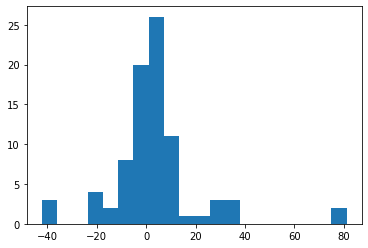

In [13]:
import matplotlib.pyplot as plt

plt.hist(soft_profit.sum(axis = (1, 2)), bins = 20)
plt.show()

In [14]:
soft_profit.mean(axis = (0,2)).reshape(-1, 60).mean(axis = 1)[1:-2].sum()

4.513963300085402e-05

In [15]:
soft_profit.mean(axis = (0,2)).reshape(-1, 60).mean(axis = 1)

array([ 5.24872522e-03,  2.03462672e-03,  5.73350115e-04,  4.85611359e-05,
        8.07086679e-06, -1.55662889e-05,  3.01602132e-05, -2.23637183e-05,
        4.93276819e-06,  4.09055701e-05,  3.81601571e-05, -3.55940893e-05,
       -8.17101590e-05, -1.41988814e-04, -3.43037574e-04, -6.90985012e-05,
       -2.11474119e-05, -6.11209826e-05,  1.37975665e-04, -9.58940986e-04,
       -3.21688385e-04, -7.99346669e-04,  4.27295727e-04,  9.99142974e-07])

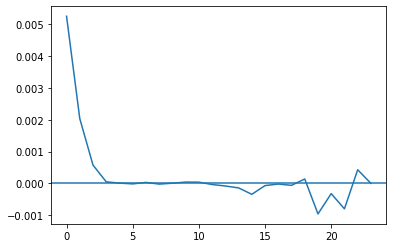

In [16]:
plt.plot(soft_profit.mean(axis = (0,2)).reshape(-1, 60).mean(axis = 1))
plt.axhline(0)

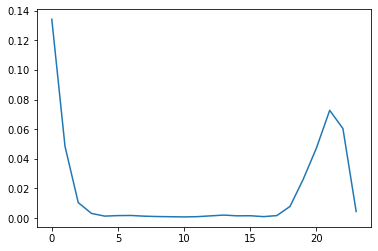

In [17]:
plt.plot(np.abs(soft_trade).mean(axis = (0,2)).reshape(-1, 60).mean(axis = 1))

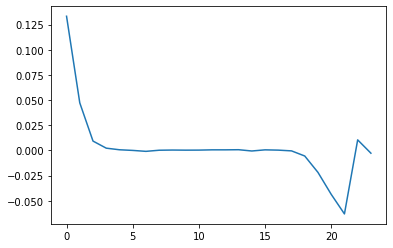

In [18]:
plt.plot(soft_trade.mean(axis = (0,2)).reshape(-1, 60).mean(axis = 1))

In [21]:
# full trade percent on 24 hours
(((np.abs(soft_trade) > .01) & (np.abs(soft_trade) < 10)).mean(axis = (0, 2)).reshape(-1, 60).mean(axis = 1) * 100).round()

array([20.,  4.,  2.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,
        1.,  2.,  3.,  2.,  1.,  1.,  1.,  0.,  1., 18.,  1.])

In [22]:
# full trade accuracy on 24 hours
np.nanmean(np.where(((np.abs(soft_trade) > .01) & (np.abs(soft_trade) < 10)), soft_profit > 0, np.nan), axis = (0, 2)).reshape(-1, 60).mean(axis = 1)

<ipython-input-22-9c8c81729e39>:2: RuntimeWarning: Mean of empty slice
  np.nanmean(np.where(((np.abs(soft_trade) > .01) & (np.abs(soft_trade) < 10)), soft_profit > 0, np.nan), axis = (0, 2)).reshape(-1, 60).mean(axis = 1)


array([0.66753067, 0.53909925,        nan,        nan,        nan,
              nan,        nan,        nan,        nan, 0.67502239,
              nan,        nan,        nan, 0.51457232, 0.45164166,
       0.46559354, 0.50304698, 0.52829841,        nan,        nan,
              nan,        nan, 0.69841071,        nan])

In [23]:
# full trade profit on 24 hours
np.nanmean(np.where(np.abs(soft_trade) > .01, soft_profit, np.nan), axis = (0, 2)).reshape(-1, 60).mean(axis = 1)

<ipython-input-23-60f52c71a734>:2: RuntimeWarning: Mean of empty slice
  np.nanmean(np.where(np.abs(soft_trade) > .01, soft_profit, np.nan), axis = (0, 2)).reshape(-1, 60).mean(axis = 1)


array([ 0.01658072,  0.00871458,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,  0.00339726,
               nan,         nan,         nan, -0.00029618, -0.00075513,
        0.00083511, -0.00014862,  0.00132696,         nan,         nan,
               nan,         nan,  0.01598958,         nan])

In [25]:
# percent full trades on all timeframes
(np.abs(soft_trade) > .2).mean(axis = (0, 1))

array([0.00046296, 0.01354167, 0.02143684, 0.0208912 , 0.04849537,
       0.04151786, 0.0411789 , 0.00825893, 0.00998677])

In [26]:
# full trade accuracy on all timeframes
np.nanmean(np.where(np.abs(soft_trade) > .2, soft_profit > 0, np.nan), axis = (0, 1))

array([0.57142857, 0.63369963, 0.64674123, 0.65769687, 0.63194681,
       0.63540422, 0.64003212, 0.56456456, 0.55215232])

In [27]:
# full trade gain on all timeframes
np.nanmean(np.where((np.abs(soft_trade) > .2) & (soft_profit > 0), soft_profit, np.nan), axis = (0, 1))

array([0.02793793, 0.01528669, 0.0187889 , 0.02732628, 0.02144163,
       0.02263214, 0.02471676, 0.02305825, 0.02987562])

In [28]:
# full trade loss on all timeframes
np.nanmean(np.where((np.abs(soft_trade) > .2) & (soft_profit < 0), soft_profit, np.nan), axis = (0, 1))

array([-0.02622606, -0.01142971, -0.01443069, -0.02069873, -0.01929041,
       -0.0194556 , -0.01955798, -0.02390294, -0.02726162])

In [21]:
# del trainer
# del model
# torch.cuda.empty_cache()

# Appendix

In [9]:
# 84 currencies
# tanh based embeddings, *no embedding norm or final norm* *no output biases*
# log returns/growth maximization!! max loss set at .5 (1% = .5 point commission)
# hidden size *320 (SMALL RUN) 5M*, ff size 1x, trade loss with inverse transformation & classification loss

# lr of 1e-3, batch size 8, adam beta .98s, no dropout or weight decay
# stds fixed, fp16
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Classification loss,Trade loss * 100,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
1300,4.402900,4.369411,3.3715,100.0055,-0.2053,-0.0427,0.3621,0.,nan,nan,0.,nan,nan,0.,nan,nan
2600,4.294700,4.361567,3.3636,100.0039,0.5157,0.1240,0.6954,0.,nan,nan,0.,nan,nan,0.,nan,nan
3900,4.289100,4.365875,3.3680,99.9985,0.5576,0.3320,0.2928,0.,nan,nan,0.,nan,nan,0.0036,84.6154,1.7617
5200,4.287600,4.362632,3.3651,100.0039,0.6259,0.1330,0.7139,0.,nan,nan,0.0097,92.4528,1.3765,0.0795,84.9885,1.1922
6500,4.284500,4.368229,3.3702,99.9981,0.867,0.503,0.3921,0.,nan,nan,0.0079,94.1860,2.0233,0.2159,71.7447,1.4800
7800,4.285600,4.355430,3.3577,100.0207,0.0510,0.0037,1.3385,0.,nan,nan,0.0200,89.4495,1.4014,0.3030,70.3243,1.469
9100,4.287500,4.364417,3.3667,99.9975,0.9555,0.3696,0.4058,0.,nan,nan,0.0113,93.4959,1.6227,0.1666,83.9581,1.4114
10400,4.280800,4.353698,3.3560,100.0084,0.1549,0.0317,0.6555,0.0014,6.6667,0.7783,0.0381,50.6024,0.6515,0.2015,56.1076,0.877
11700,4.286200,4.348947,3.3512,100.0164,0.8171,0.0724,1.4098,0.,nan,nan,0.2702,50.6970,0.8248,0.9856,55.0513,1.1088
13000,4.279900,4.352817,3.3552,100.0024,0.7989,0.1741,0.6366,0.0011,33.3333,0.1472,0.0652,57.7465,0.4720,0.2986,67.2101,1.0673


<ipython-input-3-6453d0485cd6>:17: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .75] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-6453d0485cd6>:18: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .75) & (soft_profit > 0)].mean()
<ipython-input-3-6453d0485cd6>:19: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .75) & (soft_profit < 0)].mean(),
<ipython-input-3-6453d0485cd6>:22: RuntimeWarning: Mean of empty slice.
  'medium trade accuracy': (soft_profit[(abs_trade < .75) & (abs_trade >= .45)] > 0).mean() * 100,
<ipython-input-3-6453d0485cd6>:23: RuntimeWarning: Mean of empty slice.
  'medium trade g/l': soft_profit[(abs_trade < .75) & (abs_trade >= .45) & (soft_profit > 0)].mean()
<ipython-input-3-6453d0485cd6>:24: RuntimeWarning: Me

TrainOutput(global_step=45227, training_loss=4.278258029029258, metrics={'train_runtime': 18843.813, 'train_samples_per_second': 19.201, 'train_steps_per_second': 2.4, 'total_flos': 0.0, 'train_loss': 4.278258029029258, 'epoch': 1.0})

In [9]:
# 84 currencies
# tanh based embeddings, *no embedding norm or final norm*
# log returns/growth maximization!! max loss set at .5 (1% = .5 point commission)
# hidden size *320 (SMALL RUN) 5M*, ff size 1x, trade loss with inverse transformation & classification loss

# lr of 1e-3, batch size 8, adam beta .98s, no dropout or weight decay
# stds fixed, fp16
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Classification loss,Trade loss * 100,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
1300,4.402400,4.367305,3.3693,100.0054,-0.033,-0.0055,0.4685,0.,nan,nan,0.,nan,nan,0.,nan,nan
2600,4.294500,4.359485,3.3615,100.0075,-0.1496,-0.0475,0.571,0.,nan,nan,0.,nan,nan,0.,nan,nan
3900,4.288800,4.363314,3.3653,99.9979,1.3304,0.3512,0.7401,0.0020,100.,nan,0.0365,90.932,1.6737,0.057,78.2258,1.6307
5200,4.287300,4.356721,3.359,99.9985,1.2126,0.4087,0.6293,0.0062,86.7647,1.4240,0.0419,87.2807,1.3909,0.0524,76.4912,1.083
6500,4.284100,4.366882,3.3687,99.9989,0.9084,0.3425,0.4879,0.0183,82.9146,1.4338,0.0685,80.5630,1.3871,0.1664,74.7241,1.1917
7800,4.285100,4.357679,3.3597,100.0038,1.4507,0.1747,1.0774,0.0498,79.5203,1.597,0.1857,75.2720,1.3701,0.1957,68.9817,1.4018
9100,4.287000,4.364564,3.3666,99.9994,1.1432,0.3162,0.6717,0.0122,83.4586,1.893,0.0598,84.7926,1.4284,0.0916,75.5266,0.8183
10400,4.280500,4.354684,3.3569,100.0053,0.6736,0.1566,0.766,0.0407,79.684,1.3513,0.0577,82.8025,1.2934,0.0829,59.5792,0.7066
11700,4.286000,4.350034,3.3524,100.,2.8287,0.3281,1.4849,0.1664,77.8146,1.3488,0.2462,61.5299,0.9087,0.3616,54.7764,1.1795
13000,4.279800,4.352175,3.3542,100.0013,1.3748,0.2229,0.9136,0.0211,68.6957,0.7713,0.1053,71.9023,0.6615,0.2286,76.0948,1.2121


<ipython-input-3-6453d0485cd6>:17: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .75] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-6453d0485cd6>:18: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .75) & (soft_profit > 0)].mean()
<ipython-input-3-6453d0485cd6>:19: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .75) & (soft_profit < 0)].mean(),
<ipython-input-3-6453d0485cd6>:22: RuntimeWarning: Mean of empty slice.
  'medium trade accuracy': (soft_profit[(abs_trade < .75) & (abs_trade >= .45)] > 0).mean() * 100,
<ipython-input-3-6453d0485cd6>:23: RuntimeWarning: Mean of empty slice.
  'medium trade g/l': soft_profit[(abs_trade < .75) & (abs_trade >= .45) & (soft_profit > 0)].mean()
<ipython-input-3-6453d0485cd6>:24: RuntimeWarning: Me

TrainOutput(global_step=45227, training_loss=4.27786632008742, metrics={'train_runtime': 18313.4754, 'train_samples_per_second': 19.757, 'train_steps_per_second': 2.47, 'total_flos': 0.0, 'train_loss': 4.27786632008742, 'epoch': 1.0})

In [9]:
# 84 currencies
# tanh based embeddings, *no embedding norm or final norm*
# log returns/growth maximization!! *max loss set at .5* (1% = .5 point commission)
# hidden size *512 (MED RUN) 20M*, ff size 1x, trade loss with inverse transformation & classification loss

# *lr of 1e-3*, batch size 8, adam beta .98s, no dropout or weight decay
# stds fixed, fp16
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Classification loss,Trade loss * 100,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
1300,4.378800,4.372490,3.3747,100.0044,-0.136,-0.0360,0.3192,0.,nan,nan,0.,nan,nan,0.,nan,nan
2600,4.295700,4.366624,3.3688,100.0036,0.2626,0.0881,0.4937,0.,nan,nan,0.,nan,nan,0.,nan,nan
3900,4.290100,4.362731,3.3648,99.9991,0.8274,0.4924,0.504,0.0282,66.1238,1.5128,0.0346,62.5995,1.6692,0.1473,69.6384,1.6445
5200,4.288400,4.361177,3.3634,100.0033,0.1669,0.0470,0.3867,0.,nan,nan,0.0102,87.3874,1.7727,0.0450,81.2245,1.4425
6500,4.285300,4.366254,3.3684,100.0007,0.6342,0.3019,0.4672,0.,nan,nan,0.0367,79.4486,1.2755,0.1915,72.1823,1.3077
7800,4.286400,4.355994,3.3584,100.0046,0.5997,0.0838,0.6793,0.,nan,nan,0.0324,88.3853,1.7342,0.2014,74.5098,1.3807
9100,4.287900,4.362678,3.3648,99.9982,0.7991,0.3873,0.3512,0.0001,0.,nan,0.0082,75.2809,0.9873,0.1514,76.6990,1.1457
10400,4.281400,4.356500,3.3587,100.0018,0.591,0.2416,0.4639,0.0022,54.1667,0.2435,0.042,72.2101,0.6450,0.2104,65.6482,0.9072
11700,4.286600,4.353196,3.3554,99.9957,1.4541,0.4589,0.55,0.,nan,nan,0.0247,72.119,0.5456,0.3497,72.0515,1.0375
13000,4.280300,4.354905,3.3569,100.0004,1.0828,0.2318,0.6795,0.0010,18.1818,1.3801,0.0815,68.7711,0.5480,0.2971,71.8306,1.2006


<ipython-input-3-6453d0485cd6>:17: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .75] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-6453d0485cd6>:18: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .75) & (soft_profit > 0)].mean()
<ipython-input-3-6453d0485cd6>:19: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .75) & (soft_profit < 0)].mean(),
<ipython-input-3-6453d0485cd6>:22: RuntimeWarning: Mean of empty slice.
  'medium trade accuracy': (soft_profit[(abs_trade < .75) & (abs_trade >= .45)] > 0).mean() * 100,
<ipython-input-3-6453d0485cd6>:23: RuntimeWarning: Mean of empty slice.
  'medium trade g/l': soft_profit[(abs_trade < .75) & (abs_trade >= .45) & (soft_profit > 0)].mean()
<ipython-input-3-6453d0485cd6>:24: RuntimeWarning: Me

TrainOutput(global_step=45227, training_loss=4.276890772433364, metrics={'train_runtime': 18173.9572, 'train_samples_per_second': 19.908, 'train_steps_per_second': 2.489, 'total_flos': 0.0, 'train_loss': 4.276890772433364, 'epoch': 1.0})

In [9]:
# 84 currencies
# tanh based embeddings, *embedding norm for stability*
# log returns/growth maximization!! *max loss set at .5* (1% = .5 point commission)
# hidden size *512 (MED RUN) 20M*, ff size 1x, trade loss with inverse transformation & classification loss

# DIVERGED

# *lr of 1e-3*, batch size 8, adam beta .98s, no dropout or weight decay
# stds fixed, fp16
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Classification loss,Trade loss * 100,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
1300,4.416300,4.365908,3.3678,100.0007,-0.0626,-0.1555,0.0261,0.,nan,nan,0.,nan,nan,0.,nan,nan
2600,4.300800,4.368261,3.3705,100.0004,-0.0297,-0.229,0.0160,0.,nan,nan,0.,nan,nan,0.,nan,nan
3900,4.295200,4.365646,3.3674,100.0016,-0.0932,-0.2111,0.0869,0.,nan,nan,0.,nan,nan,0.,nan,nan
5200,4.372600,4.414243,3.4169,100.0011,-0.0686,-0.1908,0.0522,0.,nan,nan,0.,nan,nan,0.,nan,nan
6500,4.393200,4.408914,3.412,100.0016,-0.1307,-0.295,0.0433,0.,nan,nan,0.,nan,nan,0.,nan,nan
7800,4.439000,4.473866,3.4777,100.0009,-0.0943,-0.2119,0.0158,0.,nan,nan,0.,nan,nan,0.,nan,nan
9100,4.461700,4.495347,3.4992,100.0010,-0.0973,-0.2125,0.0221,0.,nan,nan,0.,nan,nan,0.,nan,nan
10400,4.858200,5.221446,4.2087,100.0010,-0.0955,-0.2136,0.0226,0.,nan,nan,0.,nan,nan,0.,nan,nan
11700,6.854000,7.739451,6.7025,100.0016,-0.1161,-0.2499,0.0667,0.,nan,nan,0.,nan,nan,0.,nan,nan


<ipython-input-3-6453d0485cd6>:17: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .75] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-6453d0485cd6>:18: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .75) & (soft_profit > 0)].mean()
<ipython-input-3-6453d0485cd6>:19: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .75) & (soft_profit < 0)].mean(),
<ipython-input-3-6453d0485cd6>:22: RuntimeWarning: Mean of empty slice.
  'medium trade accuracy': (soft_profit[(abs_trade < .75) & (abs_trade >= .45)] > 0).mean() * 100,
<ipython-input-3-6453d0485cd6>:23: RuntimeWarning: Mean of empty slice.
  'medium trade g/l': soft_profit[(abs_trade < .75) & (abs_trade >= .45) & (soft_profit > 0)].mean()
<ipython-input-3-6453d0485cd6>:24: RuntimeWarning: Me

KeyboardInterrupt: 

In [9]:
# 84 currencies
# tanh based embeddings
# log returns/growth maximization!! *max loss set at .5* (1% = .5 point commission)
# hidden size *512 (MED RUN) 20M*, ff size 1x, trade loss with inverse transformation & classification loss

# DIVERGED

# *lr of 1e-3*, batch size 8, adam beta .98s, *no dropout or weight decay*
# stds fixed, fp16
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Classification loss,Trade loss * 100,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
1300,4.388800,4.367787,3.3697,100.0014,-0.1306,-0.1402,0.0426,0.,nan,nan,0.,nan,nan,0.,nan,nan
2600,4.297400,4.367381,3.3695,100.0004,-0.0219,-0.0906,0.0207,0.,nan,nan,0.,nan,nan,0.,nan,nan
3900,4.290900,4.363857,3.3660,100.0005,0.1288,0.0967,0.1669,0.,nan,nan,0.,nan,nan,0.,nan,nan
5200,4.289000,4.361834,3.3642,99.9997,0.2989,0.2579,0.1909,0.,nan,nan,0.,nan,nan,0.0121,80.3030,0.9645
6500,4.285500,4.368922,3.3709,99.9996,0.4322,0.2231,0.2561,0.,nan,nan,0.,nan,nan,0.0194,79.1469,0.7770
7800,4.286300,4.358652,3.3607,100.0109,-0.3930,-0.0616,0.6553,0.,nan,nan,0.,nan,nan,0.0047,49.0196,0.7216
9100,4.287800,4.357668,3.3598,99.9987,0.6948,0.3208,0.342,0.,nan,nan,0.0094,98.0392,2.1085,0.0707,81.8182,0.8569
10400,4.281500,4.360991,3.3630,100.0017,0.2659,0.1128,0.3109,0.0002,100.,nan,0.0284,87.3786,1.3983,0.0446,85.1546,1.2729
11700,4.289800,4.356757,3.3587,99.9981,1.1570,0.2871,0.5937,0.0010,63.6364,3.439,0.0145,90.5063,2.4655,0.0823,81.1384,1.2303
13000,4.285500,4.357792,3.3601,99.9997,1.2263,0.3689,0.7385,0.,nan,nan,0.12,83.3078,1.3337,0.2902,69.3257,0.9392


<ipython-input-3-6453d0485cd6>:17: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .75] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-6453d0485cd6>:18: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .75) & (soft_profit > 0)].mean()
<ipython-input-3-6453d0485cd6>:19: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .75) & (soft_profit < 0)].mean(),
<ipython-input-3-6453d0485cd6>:22: RuntimeWarning: Mean of empty slice.
  'medium trade accuracy': (soft_profit[(abs_trade < .75) & (abs_trade >= .45)] > 0).mean() * 100,
<ipython-input-3-6453d0485cd6>:23: RuntimeWarning: Mean of empty slice.
  'medium trade g/l': soft_profit[(abs_trade < .75) & (abs_trade >= .45) & (soft_profit > 0)].mean()
<ipython-input-3-6453d0485cd6>:24: RuntimeWarning: Me

TrainOutput(global_step=45227, training_loss=4.477708822474683, metrics={'train_runtime': 18242.5749, 'train_samples_per_second': 19.833, 'train_steps_per_second': 2.479, 'total_flos': 0.0, 'train_loss': 4.477708822474683, 'epoch': 1.0})

In [9]:
# 84 currencies
# tanh based embeddings
# log returns/growth maximization!! *max loss set at .5* (1% = .5 point commission)
# hidden size 320 (SMALL RUN) 5M, ff size 1x, trade loss with inverse transformation & classification loss

# *lr of 1e-3*, batch size 8, adam beta .98s, *DROPOUT AND WEIGHT DECAY .1*
# stds fixed, fp16
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Classification loss,Trade loss * 100,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
1300,4.414600,4.365357,3.3674,100.0009,-0.0762,-0.1104,0.036,0.,nan,nan,0.,nan,nan,0.,nan,nan
2600,4.296400,4.365189,3.3675,100.0003,-0.026,-0.2165,0.0080,0.,nan,nan,0.,nan,nan,0.,nan,nan
3900,4.291000,4.363697,3.3657,100.0010,0.0125,0.0095,0.1193,0.,nan,nan,0.,nan,nan,0.,nan,nan
5200,4.289000,4.360167,3.3623,99.9990,0.4418,0.2944,0.2320,0.,nan,nan,0.,nan,nan,0.0044,93.75,2.6532
6500,4.286000,4.372518,3.3746,99.9968,1.0074,0.3276,0.3762,0.,nan,nan,0.0045,77.5510,3.929,0.0955,76.1538,1.4838
7800,4.286900,4.359160,3.3613,100.0059,0.3521,0.0549,0.7023,0.0002,100.,nan,0.0185,89.0547,1.9108,0.1118,82.1693,1.3180
9100,4.289000,4.358775,3.361,99.9957,1.514,0.3735,0.5866,0.,nan,nan,0.0220,85.4167,1.5514,0.2741,78.3847,1.0611
10400,4.282400,4.358585,3.3607,100.0006,0.8653,0.3303,0.568,0.0018,80.,3.7087,0.0637,88.1674,1.5999,0.1236,73.0312,0.8384
11700,4.287100,4.353543,3.3557,99.9974,1.3139,0.2658,0.633,0.0001,100.,nan,0.0402,87.2146,1.7968,0.1267,78.6077,1.3132
13000,4.282600,4.355916,3.358,99.9983,1.4468,0.3033,0.7477,0.0254,82.3105,1.2033,0.2071,69.4013,0.8092,0.3221,66.5241,1.1347


<ipython-input-3-6453d0485cd6>:17: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .75] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-6453d0485cd6>:18: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .75) & (soft_profit > 0)].mean()
<ipython-input-3-6453d0485cd6>:19: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .75) & (soft_profit < 0)].mean(),
<ipython-input-3-6453d0485cd6>:22: RuntimeWarning: Mean of empty slice.
  'medium trade accuracy': (soft_profit[(abs_trade < .75) & (abs_trade >= .45)] > 0).mean() * 100,
<ipython-input-3-6453d0485cd6>:23: RuntimeWarning: Mean of empty slice.
  'medium trade g/l': soft_profit[(abs_trade < .75) & (abs_trade >= .45) & (soft_profit > 0)].mean()
<ipython-input-3-6453d0485cd6>:24: RuntimeWarning: Me

TrainOutput(global_step=45227, training_loss=4.289784152632139, metrics={'train_runtime': 18171.3074, 'train_samples_per_second': 19.911, 'train_steps_per_second': 2.489, 'total_flos': 0.0, 'train_loss': 4.289784152632139, 'epoch': 1.0})

In [9]:
# 84 currencies
# tanh based embeddings
# log returns/growth maximization!! max loss set at .9 (1% = .5 point commission)
# hidden size 320 (SMALL RUN) 5M, ff size 1x, trade loss with inverse transformation & classification loss

# *lr of 1e-3*, batch size 8, adam beta .98s, *DROPOUT AND WEIGHT DECAY .1*
# stds fixed, fp16
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Classification loss,Trade loss * 100,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
1300,4.419200,4.364779,3.3668,100.0010,-0.0931,-0.1304,0.0356,0.,nan,nan,0.,nan,nan,0.,nan,nan
2600,4.296200,4.368880,3.3711,100.0003,-0.0257,-0.2178,0.0084,0.,nan,nan,0.,nan,nan,0.,nan,nan
3900,4.291000,4.363729,3.3658,100.0005,-0.0032,-0.0057,0.0558,0.,nan,nan,0.,nan,nan,0.,nan,nan
5200,4.289600,4.358515,3.3610,100.0004,0.2675,0.1669,0.2277,0.,nan,nan,0.0012,84.6154,2.4069,0.0074,91.3580,0.9090
6500,4.286600,4.369259,3.3713,100.0011,0.0855,0.0685,0.1637,0.,nan,nan,0.,nan,nan,0.,nan,nan
7800,4.287200,4.356310,3.3586,100.0066,-0.1428,-0.0323,0.4727,0.,nan,nan,0.,nan,nan,0.0024,100.,nan
9100,4.288900,4.359476,3.3616,99.9961,1.1879,0.4333,0.4421,0.0061,78.7879,2.0783,0.0201,89.0411,1.7814,0.1463,84.1180,1.1349
10400,4.282300,4.359643,3.3618,100.,0.5908,0.2754,0.3647,0.0001,100.,nan,0.0171,87.6344,1.6847,0.0597,82.9231,1.5086
11700,4.287600,4.354145,3.3562,100.0004,1.3607,0.2387,0.8825,0.0132,81.9444,1.9648,0.0292,85.5346,1.1013,0.1981,56.4673,0.7717
13000,4.281600,4.355545,3.3575,100.0001,0.8364,0.269,0.5338,0.0018,100.,nan,0.0274,92.2819,1.3182,0.1059,71.2923,0.7577


<ipython-input-3-6453d0485cd6>:17: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .75] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-6453d0485cd6>:18: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .75) & (soft_profit > 0)].mean()
<ipython-input-3-6453d0485cd6>:19: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .75) & (soft_profit < 0)].mean(),
<ipython-input-3-6453d0485cd6>:22: RuntimeWarning: Mean of empty slice.
  'medium trade accuracy': (soft_profit[(abs_trade < .75) & (abs_trade >= .45)] > 0).mean() * 100,
<ipython-input-3-6453d0485cd6>:23: RuntimeWarning: Mean of empty slice.
  'medium trade g/l': soft_profit[(abs_trade < .75) & (abs_trade >= .45) & (soft_profit > 0)].mean()
<ipython-input-3-6453d0485cd6>:24: RuntimeWarning: Me

TrainOutput(global_step=45227, training_loss=4.288844502454286, metrics={'train_runtime': 18013.5634, 'train_samples_per_second': 20.086, 'train_steps_per_second': 2.511, 'total_flos': 0.0, 'train_loss': 4.288844502454286, 'epoch': 1.0})

In [9]:
# 84 currencies
# tanh based embeddings
# log returns/growth maximization!! max loss set at .9 (1% = .5 point commission)
# hidden size 320 (SMALL RUN) 5M, ff size 1x, *ONLY TRADE LOSS* with inverse transformation

# *lr of 1e-3*, batch size 8, adam beta .98s, *DROPOUT AND WEIGHT DECAY .1*
# stds fixed, fp16
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Classification loss,Trade loss * 100,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
1300,1.000100,1.000004,1.0000,100.0004,-0.0047,-0.0119,0.0375,0.,nan,nan,0.,nan,nan,0.0039,66.6667,0.6358
2600,1.000000,1.000002,1.0000,100.0002,-0.0191,-0.2096,0.0032,0.,nan,nan,0.,nan,nan,0.,nan,nan
3900,1.000000,1.000004,1.0000,100.0004,-0.0448,-0.2132,0.0063,0.,nan,nan,0.,nan,nan,0.,nan,nan
5200,1.000000,1.000008,1.0000,100.0007,-0.0747,-0.2116,0.0099,0.,nan,nan,0.,nan,nan,0.,nan,nan
6500,1.000000,1.000010,1.0000,100.0009,-0.0923,-0.2115,0.0120,0.,nan,nan,0.,nan,nan,0.,nan,nan
7800,1.000000,1.000010,1.0000,100.0009,-0.0970,-0.2103,0.0127,0.,nan,nan,0.,nan,nan,0.,nan,nan
9100,1.000000,1.000011,1.0000,100.0010,-0.1031,-0.2089,0.0135,0.,nan,nan,0.,nan,nan,0.,nan,nan
10400,1.000000,1.000013,1.0000,100.0012,-0.1187,-0.2095,0.0154,0.,nan,nan,0.,nan,nan,0.,nan,nan
11700,1.000000,1.000013,1.0000,100.0012,-0.118,-0.2095,0.0152,0.,nan,nan,0.,nan,nan,0.,nan,nan
13000,1.000000,1.000013,1.0000,100.0013,-0.1228,-0.2103,0.0158,0.,nan,nan,0.,nan,nan,0.,nan,nan


<ipython-input-3-6453d0485cd6>:17: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .75] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-6453d0485cd6>:18: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .75) & (soft_profit > 0)].mean()
<ipython-input-3-6453d0485cd6>:19: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .75) & (soft_profit < 0)].mean(),
<ipython-input-3-6453d0485cd6>:22: RuntimeWarning: Mean of empty slice.
  'medium trade accuracy': (soft_profit[(abs_trade < .75) & (abs_trade >= .45)] > 0).mean() * 100,
<ipython-input-3-6453d0485cd6>:23: RuntimeWarning: Mean of empty slice.
  'medium trade g/l': soft_profit[(abs_trade < .75) & (abs_trade >= .45) & (soft_profit > 0)].mean()
<ipython-input-3-6453d0485cd6>:24: RuntimeWarning: Me

TrainOutput(global_step=45227, training_loss=0.9999833441108533, metrics={'train_runtime': 17954.7713, 'train_samples_per_second': 20.151, 'train_steps_per_second': 2.519, 'total_flos': 0.0, 'train_loss': 0.9999833441108533, 'epoch': 1.0})

In [9]:
# 84 currencies
# tanh based embeddings
# log returns/growth maximization!! max loss set at .9 (1% = .5 point commission)
# hidden size 320 (SMALL RUN) 5M, ff size 1x, *ONLY TRADE LOSS*

# *lr of 1e-3*, batch size 8, adam beta .98s, *DROPOUT AND WEIGHT DECAY .1*
# stds fixed, fp16
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Classification loss,Trade loss * 100,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
1300,0.000100,0.000008,0.0000,0.0007,0.0241,0.0252,0.0983,0.,nan,nan,0.,nan,nan,0.0321,77.3639,1.0355
2600,-0.000000,-0.000031,-0.0000,-0.0033,0.5726,0.2856,0.0928,0.,nan,nan,0.0668,71.1142,1.1742,0.1084,70.5085,0.7416
3900,-0.000000,-0.000028,-0.0000,-0.0029,0.5471,0.3910,0.1186,0.,nan,nan,0.0001,100.,nan,0.2652,76.3769,1.0497
5200,-0.000000,-0.000000,-0.0000,-0.0001,0.0898,0.1083,0.0531,0.,nan,nan,0.0041,64.4444,0.581,0.0679,65.2233,0.8683
6500,-0.000000,-0.000016,-0.0000,-0.0019,0.4198,0.2211,0.1258,0.,nan,nan,0.0491,76.03,0.8778,0.1859,71.1957,1.0070
7800,-0.000000,-0.000024,-0.0000,-0.0027,0.5477,0.2666,0.1373,0.,nan,nan,0.0508,78.1193,0.8413,0.2015,72.7894,1.1108
9100,-0.000100,-0.000008,-0.0000,-0.0011,0.339,0.1906,0.1358,0.0001,100.,nan,0.0773,72.8894,1.0692,0.1614,70.6318,0.8208
10400,-0.000000,-0.000001,-0.0000,-0.0004,0.1647,0.1411,0.0845,0.,nan,nan,0.0349,72.6316,1.1987,0.1594,60.9222,0.7081
11700,-0.000000,-0.000011,-0.0000,-0.0014,0.3991,0.2089,0.1482,0.0016,82.3529,2.5471,0.0791,71.4286,1.0795,0.1998,61.0575,0.8098
13000,-0.000100,-0.000017,-0.0000,-0.0021,0.5609,0.2287,0.1959,0.0203,64.7059,0.5782,0.1055,71.4534,1.1592,0.2353,61.0851,0.8772


<ipython-input-3-6453d0485cd6>:17: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .75] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-6453d0485cd6>:18: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .75) & (soft_profit > 0)].mean()
<ipython-input-3-6453d0485cd6>:19: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .75) & (soft_profit < 0)].mean(),
<ipython-input-3-6453d0485cd6>:22: RuntimeWarning: Mean of empty slice.
  'medium trade accuracy': (soft_profit[(abs_trade < .75) & (abs_trade >= .45)] > 0).mean() * 100,
<ipython-input-3-6453d0485cd6>:23: RuntimeWarning: Mean of empty slice.
  'medium trade g/l': soft_profit[(abs_trade < .75) & (abs_trade >= .45) & (soft_profit > 0)].mean()
<ipython-input-3-6453d0485cd6>:24: RuntimeWarning: Me

TrainOutput(global_step=45227, training_loss=-8.372102393987726e-05, metrics={'train_runtime': 17659.3616, 'train_samples_per_second': 20.488, 'train_steps_per_second': 2.561, 'total_flos': 0.0, 'train_loss': -8.372102393987726e-05, 'epoch': 1.0})

In [9]:
# 84 currencies
# tanh based embeddings
# log returns/growth maximization!! max loss set at .9 *(1% = .5 point commission)*
# hidden size 320 (SMALL RUN) 5M, ff size 1x, *1x trade loss*

# *lr of 5e-4*, batch size 8, adam beta .98s, *DROPOUT AND WEIGHT DECAY .1*
# stds fixed, fp16
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Classification loss,Trade loss * 100,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
1300,3.412100,3.364296,3.3662,0.0018,-0.1703,-0.1432,0.0539,0.,nan,nan,0.,nan,nan,0.,nan,nan
2600,3.296600,3.366668,3.3689,0.0004,-0.0326,-0.1792,0.0154,0.,nan,nan,0.,nan,nan,0.,nan,nan
3900,3.290800,3.364339,3.3663,-0.0024,0.7154,0.2591,0.3376,0.,nan,nan,0.0022,83.3333,2.1356,0.0587,75.4304,1.5333
5200,3.289300,3.360924,3.3634,-0.0044,1.3646,0.2555,0.5475,0.0384,77.2727,0.5211,0.1492,71.9828,1.0523,0.1731,69.6921,1.2679
6500,3.286000,3.368513,3.3706,-0.0131,2.941,0.4224,0.7709,0.0854,77.0968,0.6696,0.3651,76.478,1.1984,0.3046,68.9686,1.362
7800,3.286900,3.360538,3.3624,0.0088,1.8325,0.1041,1.8561,0.2515,79.1088,1.0043,0.3217,71.3021,1.4031,0.2807,64.5942,1.3384
9100,3.288700,3.357801,3.36,-0.0121,3.5636,0.3257,1.2574,0.2702,79.1908,0.9775,0.3727,70.6433,1.3953,0.3049,62.2175,1.2426
10400,3.282000,3.358131,3.3603,0.0011,2.9526,0.2606,1.8736,0.2703,77.438,1.1995,0.7053,57.7624,1.0557,0.7226,57.5950,1.0512
11700,3.287400,3.354090,3.3560,0.0398,3.1784,0.0992,4.3671,0.7781,64.6323,1.0563,2.0433,56.2938,1.0816,2.0667,53.3224,0.9167
13000,3.281100,3.356800,3.3589,-0.0126,5.028,0.3195,2.0495,0.9259,72.1032,1.2207,0.5592,57.2766,1.1403,0.4185,57.5724,1.1069


<ipython-input-3-6453d0485cd6>:17: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .75] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-6453d0485cd6>:18: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .75) & (soft_profit > 0)].mean()
<ipython-input-3-6453d0485cd6>:19: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .75) & (soft_profit < 0)].mean(),
<ipython-input-3-6453d0485cd6>:22: RuntimeWarning: Mean of empty slice.
  'medium trade accuracy': (soft_profit[(abs_trade < .75) & (abs_trade >= .45)] > 0).mean() * 100,
<ipython-input-3-6453d0485cd6>:23: RuntimeWarning: Mean of empty slice.
  'medium trade g/l': soft_profit[(abs_trade < .75) & (abs_trade >= .45) & (soft_profit > 0)].mean()
<ipython-input-3-6453d0485cd6>:24: RuntimeWarning: Me

TrainOutput(global_step=45227, training_loss=3.2797528431233003, metrics={'train_runtime': 59843.9885, 'train_samples_per_second': 6.046, 'train_steps_per_second': 0.756, 'total_flos': 0.0, 'train_loss': 3.2797528431233003, 'epoch': 1.0})

In [9]:
# *84 currencies*
# tanh based embeddings
# log returns/growth maximization!! max loss set at .9
# *hidden size 320 (SMALL RUN)* 5M, ff size 1x, *1x trade loss*

# *lr of 1e-3*, batch size 8, adam beta .98s
# stds fixed, fp16
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Classification loss,Trade loss * 100,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
1300,3.378800,3.371392,3.3728,0.0621,-3.2438,-0.0749,14.4347,0.2059,52.5658,0.8651,5.6269,51.7622,0.9495,13.4117,51.1798,0.9574
2600,3.298000,3.365975,3.3681,0.0076,2.9559,0.1332,13.0549,0.3225,51.4668,0.8955,4.6035,53.8382,0.9392,11.8935,52.4780,0.965
3900,3.290900,3.363537,3.3658,-0.0352,10.9662,0.3215,16.9025,1.5383,55.2278,0.9904,7.0179,54.4974,1.0408,15.1540,52.4122,1.0307
5200,3.289100,3.367436,3.3693,0.0295,3.9944,0.1046,21.0194,4.5989,53.3626,0.9651,11.6704,51.9611,0.9733,14.5045,51.3236,0.9788
6500,3.285400,3.370147,3.372,0.0135,6.4210,0.1338,19.1474,2.5975,57.7926,0.9906,8.9613,53.5159,1.0106,15.6124,51.5224,0.9640
7800,3.285900,3.358902,3.3601,0.0976,-0.6755,-0.0092,21.5460,3.1020,54.2701,0.9748,10.1382,51.9041,0.9640,16.214,50.9229,0.9454
9100,3.287400,3.359289,3.3617,-0.0309,9.3524,0.2975,17.4345,3.0333,58.0916,1.0305,8.4716,53.7219,1.0329,12.058,51.9555,0.9935
10400,3.281200,3.358896,3.3616,-0.0514,14.2308,0.3373,18.7286,4.2784,58.4700,1.0928,8.5899,54.0748,1.0822,12.1148,51.5206,1.0444


KeyboardInterrupt: 

In [9]:
# *84 currencies*
# tanh based embeddings
# log returns/growth maximization!! max loss set at .9
# *hidden size 320 (SMALL RUN)* 5M, ff size 1x, *1x trade loss*

# *lr of 5e-4*, batch size 8, adam beta .98s
# stds fixed, fp16
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Classification loss,Trade loss * 100,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
1300,3.410400,3.364127,3.3657,0.0363,-3.3445,-0.1167,6.6080,0.,nan,nan,0.0015,68.75,0.2150,1.4477,53.2043,0.9391
2600,3.295900,3.364091,3.3662,0.0086,2.7204,0.1309,13.0055,0.4088,55.5056,0.9113,4.4043,54.3037,0.9697,10.9612,52.3909,0.9596
3900,3.289800,3.363444,3.3658,-0.0522,10.9744,0.3317,16.2190,1.6226,56.9350,1.0474,7.3176,54.6484,1.1074,13.5876,51.7942,1.0621
5200,3.287400,3.359198,3.3615,0.0019,8.6049,0.2025,21.2307,4.1519,56.1473,1.0246,11.8507,53.0815,1.0118,15.0147,51.4077,0.9910
6500,3.283600,3.371705,3.3737,0.0021,7.9078,0.1773,19.0327,3.6364,58.1529,1.0255,8.9336,53.5859,1.0015,13.8266,51.8283,0.9583
7800,3.284400,3.357296,3.3583,0.1144,0.5855,0.0065,20.5783,2.8721,59.7499,1.0548,9.1033,53.0262,0.9475,15.8671,51.3819,0.9115
9100,3.285900,3.362209,3.3645,-0.0111,9.1892,0.2324,19.8263,3.4877,57.7576,1.0352,10.1459,53.2295,1.0197,14.3215,51.7074,0.9661
10400,3.279200,3.353525,3.3561,-0.0115,10.0859,0.2131,18.0882,5.0008,57.2987,1.0368,7.6404,53.6321,1.0637,10.6753,51.4094,0.9982
11700,3.284100,3.350643,3.3530,0.0166,10.1040,0.1406,20.6071,6.3793,58.1053,1.1755,8.9036,51.6703,0.9997,11.7639,50.8648,0.9413
13000,3.277700,3.351120,3.3539,-0.0425,9.9277,0.2352,14.6177,3.0959,61.2112,1.1693,4.7512,55.0112,1.1967,8.8202,52.2943,1.0191


<ipython-input-3-6453d0485cd6>:17: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .75] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-6453d0485cd6>:18: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .75) & (soft_profit > 0)].mean()
<ipython-input-3-6453d0485cd6>:19: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .75) & (soft_profit < 0)].mean(),


TrainOutput(global_step=45227, training_loss=3.276743716937615, metrics={'train_runtime': 17853.3734, 'train_samples_per_second': 20.266, 'train_steps_per_second': 2.533, 'total_flos': 0.0, 'train_loss': 3.276743716937615, 'epoch': 1.0})

Noticing a lot of overtraining (likely due to correlations between currency pairs -- which is about the same as multi epoch training). May try simply applying weight decay of .1 and dropout of .1

These large models also seem to diverge and not have particularly good CE loss or trade ratios or sharpe

could consider strong scaling on last softmax

In [9]:
# *84 currencies*
# tanh based embeddings
# log returns/growth maximization!! max loss set at .9
# *hidden size 768* 59M params, ff size 1x, *1x trade loss*

# DIVERGES

# *lr of 5e-4*, *batch size 8*, adam beta .98s
# stds fixed, fp16
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Classification loss,Trade loss * 100,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
1300,3.366300,3.375990,3.3775,0.0596,-2.9061,-0.0651,14.98,0.0357,61.6967,0.9023,8.3142,51.5932,0.9676,12.0855,50.7061,0.9706
2600,3.299000,3.368893,3.3712,0.0021,3.4795,0.1889,14.1601,0.6608,54.1006,0.9859,6.4755,53.3343,0.9727,12.5709,52.1205,0.9799
3900,3.291500,3.365345,3.3675,-0.0170,7.8066,0.3072,17.2678,1.9930,54.7403,0.9863,8.0745,53.7997,1.0085,15.0039,52.0066,1.0151
5200,3.289000,3.367753,3.3697,0.0712,-0.7383,-0.0151,20.2519,3.6242,52.5675,0.9705,11.8065,51.1250,0.9478,14.0160,51.3651,0.9590
6500,3.285500,3.373518,3.3752,0.0305,5.8168,0.1160,21.4109,4.0917,56.5463,1.0345,11.4730,52.4796,0.9937,15.781,51.2748,0.9511
7800,3.286000,3.359468,3.3607,0.0778,1.71,0.0239,21.9008,3.2659,55.7546,1.0114,10.9417,52.0585,0.99,16.548,51.3339,0.9569
9100,3.287500,3.360921,3.3630,-0.035,8.9459,0.3247,16.9272,3.4825,55.2384,0.9595,7.4567,53.6174,1.0404,10.9900,51.8472,1.0255
10400,3.281500,3.360798,3.3629,-0.0168,9.6823,0.2232,18.9747,5.2757,55.6997,0.9509,7.8183,53.2680,1.0605,11.5862,51.6047,1.0314
11700,3.286500,3.351892,3.3543,-0.0405,12.7535,0.2113,20.0991,6.5759,55.8669,1.0389,8.5504,52.3372,1.1485,11.2607,50.6518,1.0293
13000,3.280300,3.357016,3.3596,-0.0372,7.628,0.2506,11.3056,2.3775,61.0154,1.1578,2.6127,55.6833,1.1615,5.4687,52.5196,1.0239


<ipython-input-3-6453d0485cd6>:17: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .75] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-6453d0485cd6>:18: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .75) & (soft_profit > 0)].mean()
<ipython-input-3-6453d0485cd6>:19: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .75) & (soft_profit < 0)].mean(),
<ipython-input-3-6453d0485cd6>:22: RuntimeWarning: Mean of empty slice.
  'medium trade accuracy': (soft_profit[(abs_trade < .75) & (abs_trade >= .45)] > 0).mean() * 100,
<ipython-input-3-6453d0485cd6>:23: RuntimeWarning: Mean of empty slice.
  'medium trade g/l': soft_profit[(abs_trade < .75) & (abs_trade >= .45) & (soft_profit > 0)].mean()
<ipython-input-3-6453d0485cd6>:24: RuntimeWarning: Me

KeyboardInterrupt: 

In [ ]:
# *84 currencies*
# tanh based embeddings
# log returns/growth maximization!! max loss set at .9
# *hidden size 768*, ff size 1x

# DIVERGED

# lr of 1e-3, *batch size 8*, adam beta .98s
# stds fixed, fp16
trainer.train()

# Random data experiment (to validate pipeline)

**Protocol**: The major currencies were randomized by first considering calculating the percent change from minute to minute, centering this distribution, then set the *sign* or direction of the changes randomly to be up or down with probability 50%. This protocol provably follows the martingale property for log returns (as all directionality is uniformly distributed and thus symmetric) however maintains many predictable market structure properties (i.e. time and event based volatility and even microstructure predictable volatility). Experiment 1 uses the same hyperparameters and commission level that effective for normal trading (high learning rate and doubled trade loss which seem to encourage trading). Experiment 2 does the same just removing commission.

**Results**: No profitable strategies we discovered on either experiment by the end of training (trade level of 0%). These results imply that the models are:
1. not training or recieving information that would assist trading on the validation/test sets
2. robust to outliers (i.e. volatility outliers which still remain are not traded)
3. robust to overfitting (i.e. microstructure patterns which seem to exist in training data are not traded in validation)
4. meet uncertainty with not trading
5. robust to martingales (i.e. doesn't appear to trade them)
6. quantitatively and qualitatively different when trained on real vs random data (make profit, have sharpe, discover high percentage trades, etc.)
7. robust to commission for the above results


In [9]:
# *really random data (with a proof)*
# log returns/growth maximization!! max loss set at .9 
# *NO COMMISSION*
# hidden size 320, 5 heads, ff size 1x

# lr of 1e-3, batch size 4, adam beta .98
# stds fixed, fp16
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Classification loss,Trade loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,3.528300,3.181333,3.1807,0.0005,-3.9662,-0.0941,5.3775,0.,nan,nan,0.,nan,nan,0.,nan,nan
400,3.196300,3.167823,3.1681,-0.0001,1.4114,0.131,1.7778,0.,nan,nan,0.,nan,nan,0.0091,91.3793,1.3102
600,3.190900,3.181943,3.1821,0.0000,-0.0096,-0.0658,0.0477,0.,nan,nan,0.,nan,nan,0.,nan,nan
800,3.193800,3.177546,3.1777,-0.0000,0.5018,0.2843,0.5543,0.,nan,nan,0.,nan,nan,0.0477,54.4554,1.5127
1000,3.176200,3.158208,3.1584,-0.0000,0.3941,0.3516,0.1611,0.,nan,nan,0.,nan,nan,0.0001,0.,nan
1200,3.183800,3.172053,3.1724,-0.0001,0.9283,0.0812,1.0475,0.,nan,nan,0.,nan,nan,0.,nan,nan
1400,3.174000,3.158186,3.1584,-0.0000,0.5891,0.0982,0.468,0.,nan,nan,0.,nan,nan,0.,nan,nan
1600,3.177300,3.156603,3.1567,-0.0000,0.1666,0.0432,0.3778,0.,nan,nan,0.,nan,nan,0.,nan,nan
1800,3.176200,3.155314,3.1554,0.0000,0.0105,0.0022,0.698,0.,nan,nan,0.,nan,nan,0.0005,83.3333,11.8953
2000,3.172000,3.153485,3.1537,0.0000,-0.0395,-0.0251,0.2180,0.,nan,nan,0.,nan,nan,0.,nan,nan


<ipython-input-3-86efb6d60951>:17: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .75] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-86efb6d60951>:18: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .75) & (soft_profit > 0)].mean()
<ipython-input-3-86efb6d60951>:19: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .75) & (soft_profit < 0)].mean(),
<ipython-input-3-86efb6d60951>:22: RuntimeWarning: Mean of empty slice.
  'medium trade accuracy': (soft_profit[(abs_trade < .75) & (abs_trade >= .45)] > 0).mean() * 100,
<ipython-input-3-86efb6d60951>:23: RuntimeWarning: Mean of empty slice.
  'medium trade g/l': soft_profit[(abs_trade < .75) & (abs_trade >= .45) & (soft_profit > 0)].mean()
<ipython-input-3-86efb6d60951>:24: RuntimeWarning: Me

TrainOutput(global_step=11573, training_loss=3.1741027489226, metrics={'train_runtime': 3444.2358, 'train_samples_per_second': 13.44, 'train_steps_per_second': 3.36, 'total_flos': 0.0, 'train_loss': 3.1741027489226, 'epoch': 1.0})

In [9]:
# *really random data (with a proof)*
# log returns/growth maximization!! max loss set at .9 (.01% = .5 point commission)
# hidden size 320, 5 heads, ff size 1x

# lr of 1e-3, batch size 4, adam beta .98
# stds fixed, fp16
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Classification loss,Trade loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,3.525200,3.178786,3.1786,0.0003,-1.999,-0.1207,0.8482,0.,nan,nan,0.,nan,nan,0.,nan,nan
400,3.196400,3.168370,3.1684,-0.0000,0.0364,0.1141,0.0143,0.,nan,nan,0.,nan,nan,0.,nan,nan
600,3.191300,3.183794,3.1839,0.0000,0.0004,0.0318,0.0012,0.,nan,nan,0.,nan,nan,0.,nan,nan
800,3.194000,3.178843,3.1789,-0.0000,0.0030,0.1697,0.0007,0.,nan,nan,0.,nan,nan,0.,nan,nan
1000,3.176200,3.158875,3.1590,0.0000,-0.0299,-0.0923,0.007,0.,nan,nan,0.,nan,nan,0.,nan,nan
1200,3.183700,3.172525,3.1727,-0.0000,0.1265,0.0992,0.0326,0.,nan,nan,0.,nan,nan,0.,nan,nan
1400,3.173900,3.158177,3.1583,-0.0000,0.307,0.1051,0.0621,0.,nan,nan,0.,nan,nan,0.,nan,nan
1600,3.177300,3.156856,3.1569,0.0000,-0.0647,-0.1046,0.0369,0.,nan,nan,0.,nan,nan,0.,nan,nan
1800,3.176200,3.155584,3.1557,-0.0000,0.0162,0.1299,0.0052,0.,nan,nan,0.,nan,nan,0.,nan,nan
2000,3.171700,3.153634,3.1538,-0.0000,0.0147,0.1181,0.0036,0.,nan,nan,0.,nan,nan,0.,nan,nan


<ipython-input-3-86efb6d60951>:17: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .75] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-86efb6d60951>:18: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .75) & (soft_profit > 0)].mean()
<ipython-input-3-86efb6d60951>:19: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .75) & (soft_profit < 0)].mean(),
<ipython-input-3-86efb6d60951>:22: RuntimeWarning: Mean of empty slice.
  'medium trade accuracy': (soft_profit[(abs_trade < .75) & (abs_trade >= .45)] > 0).mean() * 100,
<ipython-input-3-86efb6d60951>:23: RuntimeWarning: Mean of empty slice.
  'medium trade g/l': soft_profit[(abs_trade < .75) & (abs_trade >= .45) & (soft_profit > 0)].mean()
<ipython-input-3-86efb6d60951>:24: RuntimeWarning: Me

TrainOutput(global_step=11573, training_loss=3.17398732375802, metrics={'train_runtime': 3303.1398, 'train_samples_per_second': 14.015, 'train_steps_per_second': 3.504, 'total_flos': 0.0, 'train_loss': 3.17398732375802, 'epoch': 1.0})

# Normal trading with same hyperparameters

In [9]:
# Full majors data up to April
# *tanh based embeddings*
# log returns/growth maximization!! max loss set at .9 (.01% = .5 point commission)
# hidden size 320, 5 heads, ff size 1x

# lr of 1e-3, batch size 4, adam beta .98
# stds fixed, fp16
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Classification loss,Trade loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,3.534600,3.214738,3.2145,0.0000,0.8888,0.0650,0.8397,0.,nan,nan,0.,nan,nan,0.,nan,nan
400,3.198700,3.192871,3.1925,0.0000,-0.026,-0.0828,0.016,0.,nan,nan,0.,nan,nan,0.,nan,nan
600,3.189700,3.206654,3.2062,-0.0000,0.2908,0.1698,0.0590,0.,nan,nan,0.,nan,nan,0.,nan,nan
800,3.191100,3.184755,3.1846,0.0000,-0.0043,-0.1154,0.0021,0.,nan,nan,0.,nan,nan,0.,nan,nan
1000,3.172400,3.185741,3.1857,0.0001,-0.5353,-0.1035,0.1364,0.,nan,nan,0.,nan,nan,0.,nan,nan
1200,3.179300,3.185934,3.1860,0.0000,-0.1309,-0.1037,0.0378,0.,nan,nan,0.,nan,nan,0.,nan,nan
1400,3.174800,3.186919,3.1867,-0.0000,0.0315,0.1898,0.0086,0.,nan,nan,0.,nan,nan,0.,nan,nan
1600,3.171500,3.176858,3.1766,-0.0000,0.0494,0.0810,0.0344,0.,nan,nan,0.,nan,nan,0.0001,0.,nan
1800,3.174600,3.190657,3.1906,0.0000,-0.0015,-0.0192,0.0061,0.,nan,nan,0.,nan,nan,0.,nan,nan
2000,3.169000,3.173984,3.1743,-0.0001,1.4493,0.5214,0.3815,0.1812,75.5758,1.3221,0.0635,69.9752,1.4671,0.0543,58.2609,1.2437


<ipython-input-3-86efb6d60951>:17: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .75] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-86efb6d60951>:18: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .75) & (soft_profit > 0)].mean()
<ipython-input-3-86efb6d60951>:19: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .75) & (soft_profit < 0)].mean(),
<ipython-input-3-86efb6d60951>:22: RuntimeWarning: Mean of empty slice.
  'medium trade accuracy': (soft_profit[(abs_trade < .75) & (abs_trade >= .45)] > 0).mean() * 100,
<ipython-input-3-86efb6d60951>:23: RuntimeWarning: Mean of empty slice.
  'medium trade g/l': soft_profit[(abs_trade < .75) & (abs_trade >= .45) & (soft_profit > 0)].mean()
<ipython-input-3-86efb6d60951>:24: RuntimeWarning: Me

KeyboardInterrupt: 